
# G-MODE KPFM with Fast Free Force Recovery (F3R)
### Oak Ridge National Laboratory
### *Liam Collins, Anugrah Saxena, Rama Vasudevan and Chris Smith*
#### Additional edits: *Rajiv Giridharagopal, University of Washington*

#### Contacts: collinslf@ornl.gov (primary author) and rgiri@uw.edu 

This notebook will allow fast KPFM by recovery of the electrostatic foce directly from the photodetector response. 
Information on the procedure can be found in Collins et al. 
[DOI: 10.1021/acsnano.7b02114](http://pubs.acs.org/doi/abs/10.1021/acsnano.7b02114)) 

This notebook is designed to go through the process of F3R in G-Mode data in general.
Additional script modifications for working in Spyder can be found:
[Raj's repo](https://github.com/rajgiriUW/GKPFM)

The scripts in that repo are designed to work in Spyder for interactive data. They include much functionality removed here (automatically reloading data, saving figures to file, allowing optional flags for turning on/off certain segments, etc) at the expense of not being in Jupyter. 

This notebook and related notebooks make use of the **Pycroscopy** package. Details and helpful tutorials can be found here:
[Pycroscopy](https://pycroscopy.github.io/pycroscopy/)

Please make sure you are using the latest version. As of ~5/1/2018 there were numerous major changes to the package, and previous functionality may be broken. This notebook is currently operational.

### In this notebook the following procedured are performed:

#### (1) Models the Cantilever Transfer Function (H(w))
**(1a)** Translates Tune file to H5 <br>
**(1b)** Fits Cantilever resonances to SHO Model <br>
**(1c)** Constructs the effective cantilever transfer function (H(w)) from SHO fits of the tune. <br>

#### (2)Load, Translate and Denoize the G-KPFM data
**(2a)** Loads and translates the .mat file containing the image data to .H5 file format. <br>
**(2b)** Fourier Filters data. <br>
**(2c)** Checks Force Recovery for 1 pixel...here you need to find the phase offset used in 3. <br>
**(2d)** (Optional) PCA Denoising.<br>

#### (3) Fast Free Force Reconstruction
**(3a)** Divides filtered displacement Y(w) by the effective transfer function (H(w)). <br>
**step (2b** <br></font>
**(3b)** iFFT the response above a user defined noise floor to recovery Force in time domain.<br>
**(3c)** Phase correction (from step 2biii).<br>
**(3d)** (Optional) PCA Denoising. Usually this second set is not necessary

#### (4) Data Analysis
**(4a)** Parabolic fitting to extract CPD.<br>
**(4b)** Exponential fitting of CPD to extract time constants <br>

#### (5) Data Visualization
**(5a)** CPD in dark and illuminated case.<br>
**(5b)** Surface Photovoltage and CPD time constants.<br>
**(5c)** Static images and animation of CPD over time.<br>
**(5d)** K-means clustering of CPD data.<br>
**(5e)** SVD of CPD data in dark and illuminated case.<br>


## Installing required package

In [1]:
# Checks Python Version
import sys

if sys.version_info < (3, 5):
    print('''This notebook was optimized to work on Python 3.5.
    While it may also run on other Python versions,
    functionality and performance are not guaranteed
    Please consider upgrading your python version.''')

## Configure Notebook

In [2]:
# set up notebook to show plots within the notebook
%matplotlib inline
%precision %.4g

'''Import necessary libraries'''
# Visualization:
import matplotlib.pyplot as plt

# General utilities:
import os
import sys
from scipy.signal import correlate
from scipy.optimize import curve_fit

# Interactive Value picker
import ipywidgets as widgets

# Computation:
import numpy as np
import numpy.polynomial.polynomial as npPoly

# Parallel computation library:
try:
    import joblib
except ImportError:
    warn('joblib not found.  Will install with pip.')
    import pip
    pip.main(['install', 'joblib'])
import joblib

import h5py

# multivariate analysis:
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF

# Finally, pycroscopy itself
import pycroscopy as px
import pyUSID as usid

# Define Layouts for Widgets
lbl_layout=dict(
    width='15%'
)
widget_layout=dict(
    width='15%',margin='0px 0px 5px 12px'
)
button_layout=dict(
    width='15%',margin='0px 0px 0px 5px'
)

## Save remote data to local drive

## Step 1.) Model the Cantilever Transfer Function

First we need to read in the tune file for the cantilever your used to perform your measurment with. This tune captures the "free" SHO parameters of the cantilever.

If you have previously translated this data you can change the data type in the bottom right corner to .h5, others click the parms file.txt

To save yourself the prompt, you can directly load the file from a subfolder.

### Load Cantilever Parameters

In [43]:
data_file = r'E:\Polymer Ion Transport\ORNL\20191018_dpp3t_CB_Kcl\tune_0003'
save_figure = True
pre_load_files = True # Avoid prompts when loading data

#output_filepath = os.path.expanduser(output_filepath)

# Typical G-KPFM keeps tunes named same as parent folder
if pre_load_files is True:
    idx = data_file.rfind("\\")
    tune_file = [os.path.join(data_file, data_file[idx+1:] + '.h5'),
                 os.path.join(data_file, data_file[idx+1:] + '_bigtime_00.dat')]
    
    del(idx)
    
# For sharing this notebook specifically, adding a few hard-coded paths
tune_file = tune_file + [r'G:\Team Drives\201805_BAPI_paper_source_data\GSKPM\Testing _Notebook\Tune\Tune.h5',
                         r'G:\Team Drives\201805_BAPI_paper_source_data\GSKPM\Testing _Notebook\Tune\BAPI22_TUNE__0009_bigtime_00.dat']

### Define Cantilever Parameters

In [5]:
'''
Here you should input the calibrated parameters of the tip from your experiment.
In particular the lever sensitivity (m/V) and Spring Constant (N/m)
    (will be used to convert signals to displacement and force respectively)
'''

# 'k', 'invols', 'Thermal_Q', 'Thermal_resonance'
tune_items = {'TF_norm':[], 
              'yt0_tune':[], 
              'Yt0_tune':[], 
              'f0':[], 
              'F0':[], 
              'TF_vec':[],
              'TF_fit_vec':[]}     

cantl_parms = {'k':[], 'invols':[], 'Thermal_Q':[], 'Thermal_res':[]}

# defaults
cantl_parms['k'] = 1.7 # N/M
cantl_parms['invols'] = 82.76e-9 # m/V
cantl_parms['Thermal_Q'] = 80
cantl_parms['Thermal_res'] = 57076 #Hz

#MAPI data
cantl_parms['k'] = 2.3 # N/M
cantl_parms['invols'] = 67.56e-9 # m/V
cantl_parms['Thermal_Q'] = 83.6
cantl_parms['Thermal_res'] = 57061 #Hz

#### Step 1A) Translate Tune file to HF5 format

In [6]:
from pathlib import Path

'''
If tune file not set above, interactive.
Otherwise, defaults to finding H5 file first. 
If that fails, finds the .DAT files
'''

loadTuneValues = False # in next section, this pre-seeds variables from the H5 file if it exists

'''
If we want to pre-load files, we skip the prompt.
Otherwise, this loads from the path specified above. It searches for an H5 file first, then a .DAT file
'''

if pre_load_files is False:
    input_file_path = px.io_utils.file_dialog(caption='Select translated .h5 file or tune data',
                                            file_filter='Parameters for raw G-Line tune (*.dat);; \
                                            Translated file (*.h5)')

    tune_path, _ = os.path.split(input_file_path)
    tune_file_base_name = os.path.basename(tune_path)


else:
    for p in tune_file:
        print(p)
        file = Path(p)
        if file.is_file():
            input_file_path = p
            print('H5 file exists! Can load from source')
            loadTuneValues = True
            break
        #input_file_path = tune_file

if input_file_path.endswith('.dat') == True:
    print('Translating raw data to h5. Please wait')
    tran = px.io.translators.gmode_tune.GTuneTranslator()
    h5_path = tran.translate(input_file_path)
    print(input_file_path)
    
else:
    h5_path = input_file_path


E:\Polymer Ion Transport\ORNL\20191018_dpp3t_CB_Kcl\tune_0003\tune_0003.h5
E:\Polymer Ion Transport\ORNL\20191018_dpp3t_CB_Kcl\tune_0003\tune_0003_bigtime_00.dat
H5 file exists! Can load from source
Translating raw data to h5. Please wait
Reading line 0 of 4
Finished reading file: E:\Polymer Ion Transport\ORNL\20191018_dpp3t_CB_Kcl\tune_0003\tune_0003_bigtime_00.dat!
Reading line 0 of 4
Finished reading file: E:\Polymer Ion Transport\ORNL\20191018_dpp3t_CB_Kcl\tune_0003\tune_0003_bigtime_01.dat!
G-Tune translation complete!
E:\Polymer Ion Transport\ORNL\20191018_dpp3t_CB_Kcl\tune_0003\tune_0003_bigtime_00.dat


#### Loads data from H5 file instead

In [7]:
'''
Primarily just care about TF_norm, but loads all other values as well
'''
if loadTuneValues == True:

    hdf = hdf = h5py.File(h5_path, 'r+')
    h5_file = hdf.file
    nm_base = '/Measurement_000'
    tune_base = '/Tune_Values'
    
    if (nm_base+tune_base) in h5_file:

        grp = hdf.file[nm_base+tune_base]
        for key in cantl_parms:

            cantl_parms[key] = list(usid.hdf_utils.get_attributes(grp, key).values())[0]

        for key in tune_items:

            tune_items[key] = usid.hdf_utils.find_dataset(grp, key)[0].value

        TF_norm = tune_items['TF_norm']
    
    parms_dict = usid.hdf_utils.get_attributes(hdf.file[nm_base])

    ex_freq = parms_dict['BE_center_frequency_[Hz]']
    samp_rate = parms_dict['IO_rate_[Hz]']
    
    N_points = parms_dict['num_bins']
    N_points_per_line = parms_dict['points_per_line']
    N_points_per_pixel = parms_dict['num_bins']
    
    dt = 1/samp_rate #delta-time in seconds
    df = 1/dt #delta-frequency in Hz
    
    # Used in plotting
    w_vec2 = np.linspace(-0.5*samp_rate,
                         0.5*samp_rate - 1.0*samp_rate / N_points_per_line,
                         N_points_per_line)

#### Step 1B) Extract the Resonance Modes Considered in the Force Reconstruction

In [20]:
#define number of eigenmodes to consider
num_bandsVal=2

#define bands (center frequency +/- bandwith)
center_freq = cantl_parms['Thermal_res']
MB0_w1 = center_freq - 20E3
MB0_w2 = center_freq + 20E3
MB1_w1 = center_freq*6.25 - 20E3
MB1_w2 = center_freq*6.25 + 20E3

MB1_amp = 30E-9
MB2_amp = 1E-9

MB_parm_vec = np.array([MB1_amp,MB0_w1,MB0_w2,MB1_amp,MB1_w1,MB1_w2])
MB_parm_vec.resize(2,3)
band_edge_mat = MB_parm_vec[:,1:3]

In [21]:
# [0] and [1] are the DAQ channels, use HDFView for better understanding

hdf = px.io.HDFwriter(h5_path)
h5_file = hdf.file
h5_resp = usid.hdf_utils.find_dataset(hdf.file, 'Raw_Data')[0]  # from tip
h5_tune= usid.hdf_utils.find_dataset(hdf.file, 'Raw_Data')[-1] # chirp to tip

if not loadTuneValues: # if don't already have parms_dict, don't overwrite
    parms_dict = h5_tune.parent.parent.attrs

ex_freq = parms_dict['BE_center_frequency_[Hz]']
samp_rate = parms_dict['IO_rate_[Hz]']
N_points = parms_dict['num_bins']
N_points_per_line = parms_dict['points_per_line']
N_points_per_pixel = parms_dict['num_bins']

dt = 1/samp_rate #delta-time in seconds
df = 1/dt #delta-frequency in Hz

# Used in plotting
w_vec2 = np.linspace(-0.5*samp_rate,0.5*samp_rate - 1.0*samp_rate / N_points_per_line,N_points_per_line)

# Response
A_pd = np.mean(h5_resp, axis=0)
yt0_tune = A_pd - np.mean(A_pd)
Yt0_tune = np.fft.fftshift(np.fft.fft(yt0_tune,N_points_per_line)*dt)

# BE_wave_train
h5_spec_vals = usid.hdf_utils.get_auxiliary_datasets(h5_tune, aux_dset_name='Spectroscopic_Values')[0]
BE_pd = h5_spec_vals[0, :]

f0 = BE_pd - np.mean(BE_pd)
F0 = np.fft.fftshift(np.fft.fft(f0,N_points_per_line)*dt)

# The value here on right represents the excited bins
excited_bin_ind = np.where(np.abs(F0) > 0.5e-3)

# Transfer Function!
TF_vec = Yt0_tune/F0

C:\Users\Raj\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


#### Plot Tune

In [14]:
usid.hdf_utils.print_tree(h5_file, rel_paths=True)
print(dt)

/
Measurement_000
Measurement_000/Channel_000
Measurement_000/Channel_000/Raw_Data
Measurement_000/Channel_001
Measurement_000/Channel_001/Raw_Data
Measurement_000/Position_Indices
Measurement_000/Position_Values
Measurement_000/Spectroscopic_Indices
Measurement_000/Spectroscopic_Values
2.5e-07


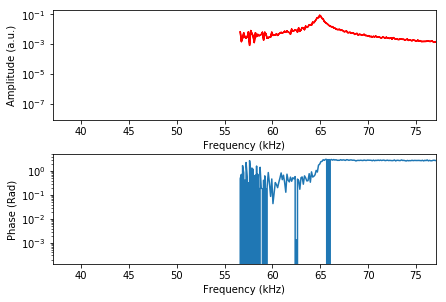

In [24]:
plt.figure(2)
plt.subplot(2,1,1)
#plt.semilogy(np.abs(w_vec2[excited_bin_ind])*1E-6,
#             np.abs(TF_vec[excited_bin_ind]))

plt.semilogy(np.abs(w_vec2[excited_bin_ind])*1E-3,
             np.abs(TF_vec[excited_bin_ind]), 'r')
plt.semilogy(np.abs(w_vec2[excited_bin_ind])*1E-6,
             np.abs(Yt0_tune[excited_bin_ind]), 'b')
plt.semilogy(np.abs(w_vec2[excited_bin_ind])*1E-6,
             np.abs(F0[excited_bin_ind]), 'k')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Amplitude (a.u.)')
plt.xlim([band_edge_mat[0,0]*1e-3, band_edge_mat[0,1]*1e-3])
plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)
plt.subplot(2,1,2)
plt.semilogy(np.abs(w_vec2[excited_bin_ind])*1E-3,
             np.angle(TF_vec[excited_bin_ind]))
plt.xlabel('Frequency (kHz)')
plt.ylabel('Phase (Rad)')
plt.xlim([band_edge_mat[0,0]*1e-3, band_edge_mat[0,1]*1e-3])
plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)

### Step 1C) Construct an effective Transfer function (TF_Norm) from SHO fits

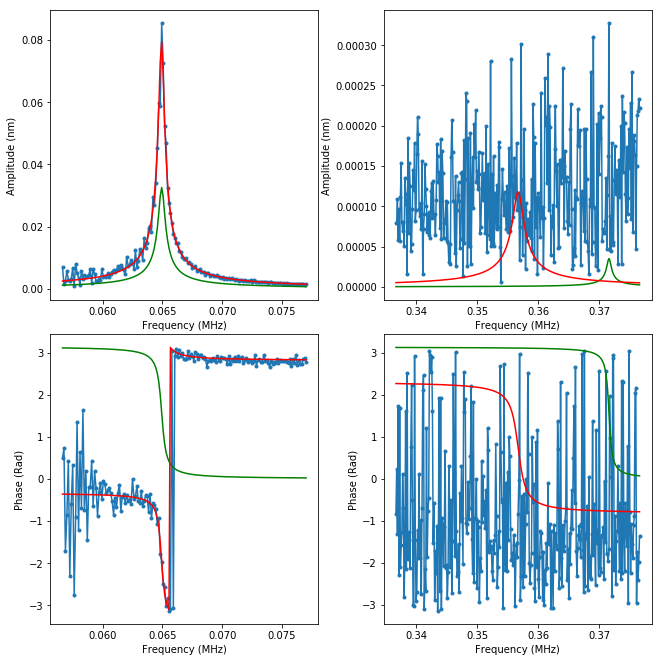

In [25]:
TunePhase = -np.pi
num_bands = band_edge_mat.shape[0]
coef_mat = np.zeros((num_bands,4))
coef_guess_vec = np.zeros((4))

# wb is an array of frequency points only where F0 above noise floor
wb = w_vec2[excited_bin_ind]

# Fit function for transfer function
TF_fit_vec = np.zeros((w_vec2.shape))
TFb_vec = TF_vec[excited_bin_ind]

# k1 = eigenmodes of cantilever to evaluate. Default = 2
Q_guesses = [120, 500, 700]

for k1 in range(num_bandsVal):
    
    # locate the fitting region
        # bin_ind1 is where band_edge is in the wb array
        # wbb is an array that spans this region for fitting purposes
    w1 = band_edge_mat[k1][0]
    w2 = band_edge_mat[k1][1]
    bin_ind1 = np.where(np.abs(w1-wb) == np.min(np.abs(w1-wb)))[0][0]
    bin_ind2 = np.where(np.abs(w2-wb) == np.min(np.abs(w2-wb)))[0][0]
    wbb = wb[bin_ind1:bin_ind2+1].T/1e6

    response_vec = TFb_vec[bin_ind1:bin_ind2+1].T
    response_mat = np.array([np.real(response_vec), np.imag(response_vec)]).T
    
    # initial guesses    
    A_max_ind = np.argmax(np.abs(response_vec))
    A_max = response_vec[A_max_ind]
    Q_guess = Q_guesses[k1]
    A_guess = A_max/Q_guess
    wo_guess = wbb[A_max_ind]
    phi_guess = TunePhase
    coef_guess_vec = [np.real(A_guess),
                      wo_guess,
                      Q_guess,
                      phi_guess]

    coef_vec = px.analysis.utils.be_sho.SHOestimateGuess(response_vec, wbb, 10)
    response_guess_vec = px.analysis.utils.be_sho.SHOfunc(coef_guess_vec, wbb)
    response_fit_vec = px.analysis.utils.be_sho.SHOfunc(coef_vec, wbb)

    # Saves the response in MHz, not used anywhere else
    coef_vec[1] = coef_vec[1]*1E6 #convert to MHz
    coef_mat[k1,:] = coef_vec
    response_fit_full_vec = px.analysis.utils.be_sho.SHOfunc(coef_vec,w_vec2)
    TF_fit_vec = TF_fit_vec + response_fit_full_vec # check for length and dimension

    # Plot: blue = data, green = initial guess, red = fit
    fig= plt.figure(10, figsize=(9,9))
    plt.subplot(num_bands,2,k1+1)
    plt.plot(wbb,np.abs(response_vec),'.-')
    plt.plot(wbb,np.abs(response_guess_vec),c='g')
    plt.plot(wbb,np.abs(response_fit_vec),c='r')
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Amplitude (nm)')
    plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)

    #plt.figure(11)
    plt.subplot(num_bands,2,(k1+1)+2)
    plt.plot(wbb,np.angle(response_vec),'.-')
    plt.plot(wbb,np.angle(response_guess_vec),'g')
    plt.plot(wbb,np.angle(response_fit_vec),'r')
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Phase (Rad)')
    plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)

    if save_figure == True:
        fig.savefig(data_file+'\SHOFitting.eps', format='eps')
        fig.savefig(data_file+'\SHOFitting.tif', format='tiff')

Q = coef_mat[0,2]
TF_norm = ((TF_fit_vec- np.min(np.abs(TF_fit_vec)))/ np.max(np.abs(TF_fit_vec))-
           np.min(np.abs(TF_fit_vec))) * Q

In [40]:
#tf_grp = usid.hdf_utils.create_indexed_group(h5_file['/'], 'Tune_Function')
usid.hdf_utils.print_tree(h5_file, rel_paths=True)
#del h5_file['/Tune_Function_000']

/
Measurement_000
Measurement_000/Channel_000
Measurement_000/Channel_000/Raw_Data
Measurement_000/Channel_001
Measurement_000/Channel_001/Raw_Data
Measurement_000/Position_Indices
Measurement_000/Position_Values
Measurement_000/Spectroscopic_Indices
Measurement_000/Spectroscopic_Values
Tune_Function_000
Tune_Function_000/F0
Tune_Function_000/Position_Indices
Tune_Function_000/Position_Values
Tune_Function_000/Spectroscopic_Indices
Tune_Function_000/Spectroscopic_Values
Tune_Function_000/TF_fit_vec
Tune_Function_000/TF_vec
Tune_Function_000/Tune_Data
Tune_Function_000/Y_freq
Tune_Function_000/f0
Tune_Function_000/y_time


#### Saves Data to H5 File (optional)

In [39]:
#%% Saves data to the h5 File
'''
Need to save cantilever parameters, TF_nom, Q, yt0_tune, Yt0, f0, F0, TF_vec

'''

tf_grp = usid.hdf_utils.create_indexed_group(h5_file['/'], 'Tune_Function')
tf_pos_dim = usid.hdf_utils.Dimension('Single Step', 'a.u.', 1)
tf_spec_dim = usid.hdf_utils.Dimension('Frequency', 'MHz', w_vec2)
h5_tf = usid.hdf_utils.write_main_dataset(tf_grp, 
                                          TF_norm.reshape(1, -1), 
                                          'Tune_Data', 
                                          'Response',
                                          'a.u.',
                                          tf_pos_dim, 
                                          tf_spec_dim)



In [ ]:
tune_items = {'y_time':yt0_tune, 
              'Y_freq':Yt0_tune, 
              'f0':f0, 
              'F0':F0, 
              'TF_vec':TF_vec,
              'TF_fit_vec':TF_fit_vec}     

for key, val in tune_items.items():

    tf_grp.create_dataset(key, data=val)

#### Separate close file to allow debugging without errors

In [41]:
hdf.close()

# Step (2) Load, Translate and Denoise the G-KPFM data 

At this point, we now are ready to load actual data! 

For many operations, we will want to be iterating through and processing data after some trial and errors. One of the benefits of Pycroscopy is that all processing is stored in the HDF5 file. The easiest way to handle that is in an interactive shell (Spyder). This notebook instead does not dynamically allow you to view the H5 contents but instead shows how to go through processing the G-KPFM data.

#### Step (2a) Load and Translates image file to .H5 file format.

In [44]:
''' Set up some initial parameters.
Set the image length and height directly here. 
Aspect is for plotting as, by default, the G-Mode data acquisition is 4 x 1
'''
img_length = 30e-6
img_height = 7.5e-6
aspect = 0.5 # due to G-mode approach
light_on_time = [3,7]

In [46]:
'''Loads data'''
from pathlib import Path
import os
pre_load_files = False
save_figure = True # do you want to save these to file

# Set save file location
output_filepath = r'E:\Polymer Ion Transport\ORNL\20191018_dpp3t_CB_Kcl\dpp3t_cb_1Vdc_kcl_zoom_0005'
data_file = '' # if reading an H5 file directly and want to skip the prompt, type the full path here e.g. r'E:\Data.H5'
output_filepath = os.path.expanduser(output_filepath)

print('#### IMAGE LENGTH =',img_length,'####')

if pre_load_files is False:
    input_file_path = usid.io_utils.file_dialog(caption='Select translated .h5 file or raw experiment data',
                                            file_filter='Parameters for raw G-Line data (*.dat);; \
                                            Translated file (*.h5)')
else:
    input_file_path = output_filepath
    
folder_path, _ = os.path.split(input_file_path)

if input_file_path.endswith('.dat'):
    print('Translating raw data to h5. Please wait')
    tran = px.io.translators.gmode_line.GLineTranslator()
    h5_path = tran.translate(input_file_path)
    hdf = px.io.HDFwriter(h5_path)
    preLoaded = False
else:
    h5_path = input_file_path
    hdf = px.io.HDFwriter(h5_path)
    px.hdf_utils.print_tree(hdf.file, rel_paths=True)
    preLoaded = True #for pre-loading some data
    
# to automatically set light_on times is "ms" or "us" in the filename...for illuminated data.
'''
a = output_filepath.find('ms')
b = output_filepath.find('us')
if a != -1:
    tm = int(output_filepath[a-1])
    light_on_time = [1, 1+tm]  # ms   
elif b != -1:
    tm = int(output_filepath[b-3:b])
    light_on_time = [1, 1+tm/1000]  # ms
del(a)
del(b)
'''

#### IMAGE LENGTH = 3e-05 ####
Translating raw data to h5. Please wait
Reading line 0 of 64
Reading line 10 of 64
Reading line 20 of 64
Reading line 30 of 64
Reading line 40 of 64
Reading line 50 of 64
Reading line 60 of 64
Finished reading file: E:\Polymer Ion Transport\ORNL\20191018_dpp3t_CB_Kcl\dpp3t_cb_1Vdc_kcl_zoom_0005\dpp3t_cb_1Vdc_kcl_zoom_0005_bigtime_00.dat!
Reading line 0 of 64
Reading line 10 of 64
Reading line 20 of 64
Reading line 30 of 64
Reading line 40 of 64
Reading line 50 of 64
Reading line 60 of 64
Finished reading file: E:\Polymer Ion Transport\ORNL\20191018_dpp3t_CB_Kcl\dpp3t_cb_1Vdc_kcl_zoom_0005\dpp3t_cb_1Vdc_kcl_zoom_0005_bigtime_01.dat!
G-Line translation complete!


"\na = output_filepath.find('ms')\nb = output_filepath.find('us')\nif a != -1:\n    tm = int(output_filepath[a-1])\n    light_on_time = [1, 1+tm]  # ms   \nelif b != -1:\n    tm = int(output_filepath[b-3:b])\n    light_on_time = [1, 1+tm/1000]  # ms\ndel(a)\ndel(b)\n"

#### Extract some relevant parameters

In [48]:
# Getting ancillary information and other parameters
h5_file = hdf.file
h5_main = usid.hdf_utils.find_dataset(hdf.file,'Raw_Data')[0]
h5_spec_vals = usid.hdf_utils.get_auxiliary_datasets(h5_main, aux_dset_name='Spectroscopic_Values')[0]
h5_spec_inds= usid.hdf_utils.get_auxiliary_datasets(h5_main, aux_dset_name='Spectroscopic_Indices')[0]

# General parameters
parms_dict = h5_main.parent.parent.attrs
samp_rate = parms_dict['IO_rate_[Hz]']
ex_freq = parms_dict['BE_center_frequency_[Hz]']
num_rows = parms_dict['grid_num_rows']
num_cols = parms_dict['grid_num_cols']
parms_dict['num_rows'] = num_rows
parms_dict['num_cols'] = num_cols
h5_pos_vals = usid.hdf_utils.get_auxiliary_datasets(h5_main, aux_dset_name='Position_Values')[0]
h5_pos_inds = usid.hdf_utils.get_auxiliary_datasets(h5_main, aux_dset_name='Position_Indices')[0]
num_pts = h5_main.shape[1]
pnts_per_pix=int(num_pts/num_cols)

# Adding image size to the parameters
parms_dict['FastScanSize'] = img_length
parms_dict['SlowScanSize'] = img_height

N_points = parms_dict['num_bins']
N_points_per_pixel = parms_dict['num_bins']
time_per_osc = (1/parms_dict['BE_center_frequency_[Hz]'])
IO_rate = parms_dict['IO_rate_[Hz]']     #sampling_rate
parms_dict['sampling_rate'] = IO_rate
pnts_per_period = IO_rate * time_per_osc #points per oscillation period
pxl_time = N_points_per_pixel/IO_rate    #seconds per pixel
num_periods = int(pxl_time/time_per_osc) #total # of periods per pixel, should be an integer

# Needed for some backwards compatibility
parms_dict['total_time'] = pxl_time
parms_dict['trigger'] = 0
parms_dict['length'] = img_length
parms_dict['height'] = img_height
parms_dict['light_on_time'] = light_on_time
grp_CPD = px.io.VirtualGroup(h5_main.parent.parent.name)
grp_CPD.attrs['length'] = img_length
grp_CPD.attrs['height'] = img_height


# Excitation waveform for a single pixel
pixel_ex_wfm = h5_spec_vals[0, :int(h5_spec_vals.shape[1]/num_cols)]

# Excitation waveform for a single line / row of data
excit_wfm = h5_spec_vals.value

# Preparing the frequency axis:
w_vec = 1E-3*np.linspace(-0.5*samp_rate, 0.5*samp_rate - samp_rate/num_pts, num_pts)
w_vec_pix = 1E-3*np.linspace(-0.5*samp_rate, 0.5*samp_rate - samp_rate/pnts_per_pix, pnts_per_pix)

# Preparing the time axis:
t_vec_line = 1E3*np.linspace(0, num_pts/samp_rate, num_pts)
t_vec_pix = 1E3*np.linspace(0, pnts_per_pix/samp_rate, pnts_per_pix)

# Dimension objects
rows_vals = np.linspace(0, img_height, num_rows)
cols_vals = np.linspace(0, img_length, num_cols)
time_vals = t_vec_pix

# Correctly adds the ancillary datasets
pos_dims = [usid.write_utils.Dimension('Cols', 'm', cols_vals),
            usid.write_utils.Dimension('Rows', 'm', rows_vals)]
spec_dims = [usid.write_utils.Dimension('Time', 's', time_vals)]

#### Loads previous data if H5 file loaded directly

In [49]:
# Loads some functions used later for fitting and loading

def fitexp(x, A, tau, y0, x0):
    return A * np.exp(-(x - x0) /tau) + y0

def fitbiexp(x, A1, tau1, A2, tau2, y0, x0):
    return A1*np.exp(-(x-x0)/tau1) + A2*np.exp(-(x-x0)/tau2) + y0

def h5_list(h5file, key):
    '''
    Returns list of names matching a key in the h5 group passed
    h5file = hdf.file['/Measurement_000/Channel_000'] or similar
    '''
    names = []
    for i in h5file:
        if key in i:
            names.append(i)
            
    return names

In [50]:
'''
By default this will load the most recent of each file matching the respective name. 
That is, if there are 8 CPDs generated from previous processing, it will load the 8th one.
'''

if preLoaded == True:
    ''' 
    Loads all the previous missing data so we can skip around to relevant functions
    '''
    print('#### Loading from saved H5 ####')
    # Group addresses, assume only first members are important
    nm_base = '/Measurement_000/Channel_000'
    nm_filt_resh = 'Filtered_Data-Reshape_000'
    nm_h5_resh = 'h5_F3R-Reshape_000'
    nm_SVD = 'Reshaped_Data-SVD_000'
    nm_CPD = nm_base + '/Raw_Data-CPD'
    
    grp = hdf.file['/Measurement_000/Channel_000']
    h5_filt = px.hdf_utils.find_dataset(grp, 'Filtered_Data')[0]
    h5_resh = px.hdf_utils.find_dataset(hdf.file['/'.join([h5_filt.parent.name, nm_filt_resh])],
                                      'Reshaped_Data')[0]
    h5_resh_grp = h5_resh.parent
  
    # Gets the "last" Rebuilt SVD Data if there's more than 1
    names = h5_list(hdf.file['/'.join([h5_filt.parent.name,nm_filt_resh])],
                    'Reshaped_Data-SVD')
    if any(names):
        nm_filt_resh_SVD = names[-1]
        
        # Filtered Data    
        PCA_clean_data_prerecon = px.hdf_utils.find_dataset(hdf.file['/'.join([h5_resh_grp.name, nm_filt_resh_SVD])],'Rebuilt_Data')
        
        if PCA_clean_data_prerecon == []:
            PCA_pre_reconstruction_clean = False
        else:
            PCA_clean_data_prerecon = PCA_clean_data_prerecon[0]
            h5_svd_group = PCA_clean_data_prerecon.parent.parent
            h5_Uprerecon = h5_svd_group['U']
            h5_Vprerecon = h5_svd_group['V']
            h5_Sprerecon = h5_svd_group['S']
        
            abun_maps_prefilter = np.reshape(h5_Uprerecon[:,:25], (num_rows, num_cols,-1))

    else:
        PCA_pre_reconstruction_clean = False
    
    # Post-F3R
    h5_F3R = px.hdf_utils.find_dataset(grp, 'h5_F3R')[0]
    h5_F3Rresh_grp = h5_F3R.parent
    
    # Get correct reshaped data
    names = h5_list(hdf.file[h5_F3R.parent.name],'h5_F3R-Reshape')
    nm_h5_resh = names[-1]
    h5_F3Rresh = px.hdf_utils.find_dataset(hdf.file['/'.join([h5_F3R.parent.name, nm_h5_resh])],'Reshaped_Data')[0]
    PCA_clean_data_postrecon = px.hdf_utils.find_dataset(hdf.file['/'.join([h5_F3Rresh.parent.name, nm_SVD])],
                                                  'Rebuilt_Data')
    if PCA_clean_data_postrecon == []:
        PCA_post_reconstruction_clean = False
    else:
        PCA_post_reconstruction_clean = True
        PCA_clean_data_postrecon = PCA_clean_data_postrecon[0]
        
        h5_svd_group = PCA_clean_data_postrecon.parent.parent
        h5_U = h5_svd_group['U']
        h5_V = h5_svd_group['V']
        h5_S = h5_svd_group['S']
    
        abun_maps_postfilter = np.reshape(h5_U[:,:25], (num_rows, num_cols,-1))
    
    # CPD
    CPD = px.hdf_utils.find_dataset(grp, 'CPD')[0]
    CPD_on_time = px.hdf_utils.find_dataset(grp, 'CPD_on_time')[0]
    CPD_off_time = px.hdf_utils.find_dataset(grp, 'CPD_off_time')[0]
    if type(CPD_on_time != np.ndarray):
        CPD_on_time = CPD_on_time.value
        CPD_off_time = CPD_off_time.value
    
    # Create CPD average image matrices
    CPD_off_avg = np.zeros(CPD_on_time.shape)
    CPD_on_avg = np.zeros(CPD_on_time.shape)
    SPV = CPD_on_avg - CPD_off_avg
    parms_dict = h5_main.parent.parent.attrs
    num_rows = parms_dict['grid_num_rows']
    num_cols = parms_dict['grid_num_cols']
    dtCPD = pxl_time/CPD.shape[1] 
    p_on = int(light_on_time[0]*1e-3 / dtCPD) 
    p_off = int(light_on_time[1]*1e-3 / dtCPD) 
    CPD_on = CPD[:, p_on:p_off]
    CPD_off = CPD[:, p_off:]
    
    for r in np.arange(CPD_on_time.shape[0]):
        for c in np.arange(CPD_on_time.shape[1]):
            CPD_off_avg[r][c] = np.mean(CPD[r*num_cols + c,p_off:])
            CPD_on_avg[r][c] = np.mean(CPD[r*num_cols + c,p_on:p_off])
    
    # Parabola fit
    wHfit3 = px.hdf_utils.find_dataset(hdf.file['/'],'parafit_main')[0]
    reconstruct = False

    # Reconstruct CPD data from parabola fit file (used optionally later)
    CPD_recon = np.zeros([num_rows*num_cols, wHfit3.shape[1]])
    CPD_grad = np.zeros([num_rows*num_cols, wHfit3.shape[1]])
        
    CPD_recon[:,:] = -0.5*np.divide(wHfit3[:,:,1],wHfit3[:,:,2]) # vertex of parabola
    CPD_grad[:,:] = wHfit3[:,:,2]
    
    CPD_grad_resh_on_avg = np.zeros(CPD_on_time.shape)
    CPD_grad_resh_off_avg = np.zeros(CPD_on_time.shape)
    
    for r in np.arange(CPD_on_time.shape[0]):
        for c in np.arange(CPD_on_time.shape[1]):
            CPD_grad_resh_off_avg[r][c] = np.mean(CPD_grad[r*num_cols + c,p_off:])
            CPD_grad_resh_on_avg[r][c] = np.mean(CPD_grad[r*num_cols + c,p_on:p_off])
    
    dset = wHfit3[:,:,:]

    pnts_per_CPDpix = CPD_recon.shape[1]

#### Step 2b Fourier Filter data.

-- Define filter parameters in first cell <br>
-- Then test on a single row <br>
-- Finally perform on full dataset <br>

**<font color=blue> Here you can play with Noise tolerance <br></font>**

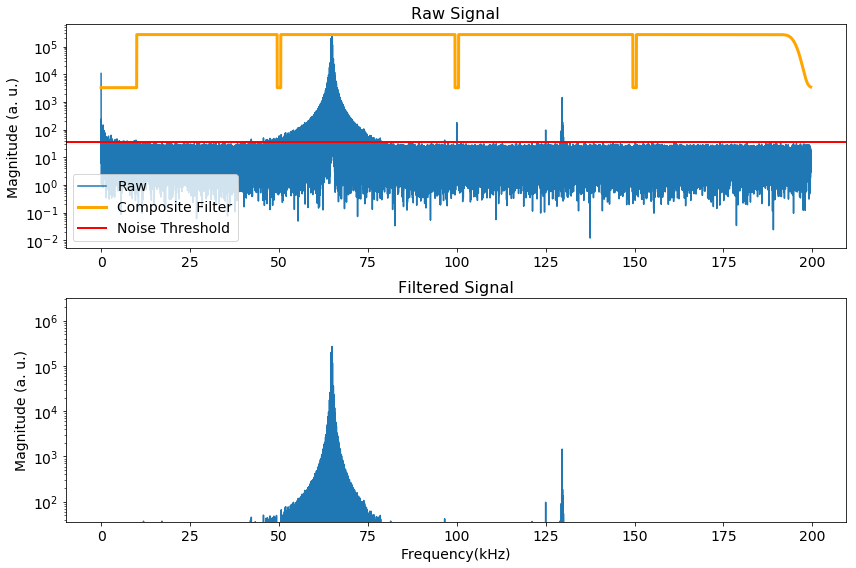

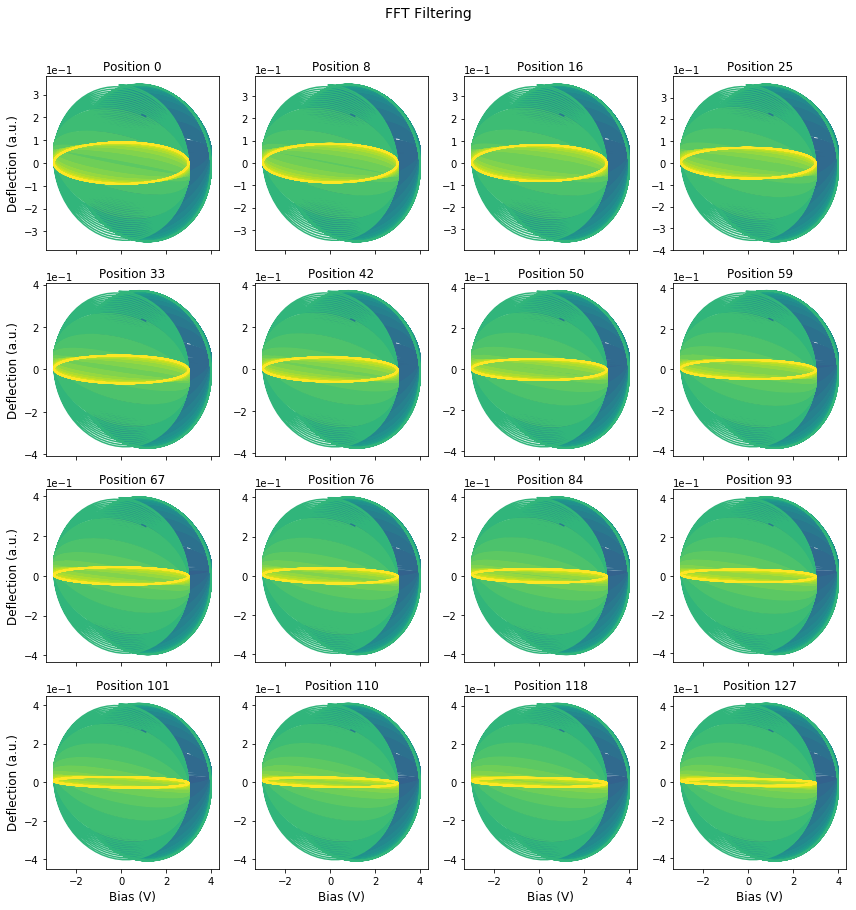

In [55]:
# Set Filter parameters here:
num_spectral_pts = h5_main.shape[1]
#hpf = px.processing.fft.HarmonicPassFilter(num_pts, samp_rate, ex_freq, 1E+3, 10)

#default filtering, note the bandwidths --> DC filtering and certain noise peaks
lpf = px.processing.fft.LowPassFilter(num_pts, samp_rate, 200E+3)
nbf = px.processing.fft.NoiseBandFilter(num_pts, samp_rate, 
                                        [5E3, 50E3, 100E3, 150E3, 200E3],
                                        [10E3, 1E3, 1E3, 1E3, 1E3])

#no DC filtering
#nbf = px.processing.fft.NoiseBandFilter(num_pts, samp_rate, 
#                                        [50E3, 100E3, 125E3],
#                                        [1E3, 1E3, 1.5E3])

freq_filts = [lpf, nbf]
noise_tolerance = 50e-7

narrowband = False
if narrowband == True:
    nbf = px.processing.fft.HarmonicPassFilter(num_pts, samp_rate, ex_freq, 1e3, 5)
    freq_filts = [nbf]

# Test filter on a single line:
row_ind = 12
filt_line, fig_filt, axes_filt = px.processing.gmode_utils.test_filter(h5_main[row_ind],
                                                                       frequency_filters=freq_filts,
                                                                       noise_threshold=noise_tolerance,
                                                                       show_plots=True)

if save_figure == True:
    fig = fig_filt
    fig.savefig(output_filepath+'\FFTFiltering.eps', format='eps')
    fig.savefig(output_filepath+'\FFTFiltering.tif', format='tiff')

filt_row = filt_line.reshape(-1, pixel_ex_wfm.size)
fig, axes = usid.plot_utils.plot_curves(pixel_ex_wfm, filt_row,use_rainbow_plots=True, 
                                     x_label='Bias (V)', title='FFT Filtering',
                                     num_plots=16, y_label='Deflection (a.u.)')

#### Step 2B.i) Testing F3R and finding phase on the Filtered row data from previous step

We need to find the phase offset between the measured response and drive voltage.
Adjust phase to close the parabola in the second set of images

This segment does two things:

    0) optional: Try and auto-find the phase-offset. 
    1) Tests whether the above filters are effective (FFT plot) and shows the result
    2) Tests if the phase-offset is correct to account for cable pathlengths


#### Step 2B.i.0) Finds the optimal phase-offset 
###### (can skip to Step 2B.i.1 if you know the phase or to search manually)

In [65]:
# Calculates NoiseLimit
search_phase = False # set to true to search, this is slow!

if search_phase == True:
    
    fft_h5row = np.fft.fftshift(np.fft.fft(h5_main[row_ind]))
    noise_floor = px.processing.fft.get_noise_floor(fft_h5row, noise_tolerance)[0]
    print('Noise floor = ', noise_floor)
    Noiselimit = np.ceil(noise_floor)

    G_line = np.zeros(w_vec2.size,dtype=complex)         # G = raw
    G_wPhase_line = np.zeros(w_vec2.size,dtype=complex)  # G_wphase = phase-shifted
    
    signal_ind_vec = np.arange(w_vec2.size)
    ind_drive = (np.abs(w_vec2-ex_freq)).argmin()
    
    test_line = filt_line-np.mean(filt_line)
    test_line = np.fft.fftshift(np.fft.fft(test_line))
    signal_kill = np.where(np.abs(test_line) < Noiselimit)
    signal_ind_vec = np.delete(signal_ind_vec, signal_kill)

    fits = []
    xpts = np.arange(-2*np.pi, 2*np.pi, 0.1)
    for i in xpts:

        test_shifted = (test_line)*np.exp(-1j*w_vec2/(w_vec2[ind_drive])*i)
        G_wPhase_line[signal_ind_vec] = test_shifted[signal_ind_vec]
        G_wPhase_line = (G_wPhase_line/TF_norm)
        G_wPhase_time_line = np.real(np.fft.ifft(np.fft.ifftshift(G_wPhase_line)))
        phaseshifted = G_wPhase_time_line.reshape(-1, pixel_ex_wfm.size)

        p1, _ = npPoly.polyfit(pixel_ex_wfm[8:24], phaseshifted[0,8:24], 2, full=True)
        p2, _ = npPoly.polyfit(pixel_ex_wfm[24:40], phaseshifted[0,24:40], 2, full=True)

        fit1 = -0.5*p1[1]/p1[2]
        fit2 = -0.5*p2[1]/p2[2]
        fits.append(np.abs(fit2-fit1))

    print(np.argmin(fits),xpts[np.argmin(fits)])
    ph = xpts[np.argmin(fits)]

#### Step 2B.i.1) Finds the optimal phase-offset 

Noise floor =  35.994179110357344


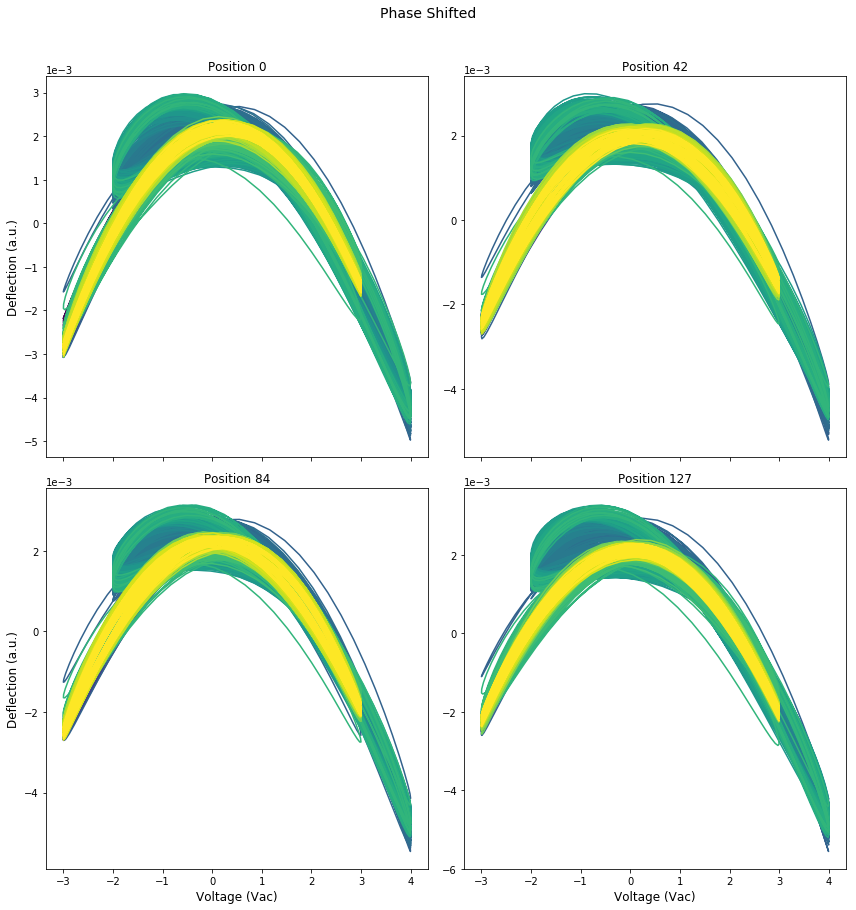

In [67]:
# Try Force Conversion on Filtered data

# Phase Offset
ph = -.38   # phase from cable delays between excitation and response. Set this manually!

# Calculates NoiseLimit
fft_h5row = np.fft.fftshift(np.fft.fft(h5_main[row_ind]))
noise_floor = px.processing.fft.get_noise_floor(fft_h5row, noise_tolerance)[0]
print('Noise floor = ', noise_floor)
Noiselimit = np.ceil(noise_floor)

# Try Force Conversion on Filtered data of single line (row_ind above)
G_line = np.zeros(w_vec2.size,dtype=complex)         # G = raw
G_wPhase_line = np.zeros(w_vec2.size,dtype=complex)  # G_wphase = phase-shifted

signal_ind_vec = np.arange(w_vec2.size)
ind_drive = (np.abs(w_vec2-ex_freq)).argmin()

# filt_line is from filtered data above
test_line = filt_line-np.mean(filt_line)
test_line = np.fft.fftshift(np.fft.fft(test_line))
signal_kill = np.where(np.abs(test_line) < Noiselimit)
signal_ind_vec = np.delete(signal_ind_vec, signal_kill)

# Original/raw data; TF_norm is from the Tune file transfer function
G_line[signal_ind_vec] = test_line[signal_ind_vec]
G_line = (G_line/TF_norm)
G_time_line = np.real(np.fft.ifft(np.fft.ifftshift(G_line))) #time-domain 

# Phase-shifted data
test_shifted = (test_line)*np.exp(-1j*w_vec2/(w_vec2[ind_drive])*ph)
G_wPhase_line[signal_ind_vec] = test_shifted[signal_ind_vec]
G_wPhase_line = (G_wPhase_line/TF_norm)
G_wPhase_time_line = np.real(np.fft.ifft(np.fft.ifftshift(G_wPhase_line)))

# On a single line, row_ind is above in previous cell
FRaw_resp = np.fft.fftshift(np.fft.fft(h5_main[row_ind]))

phaseshifted = G_wPhase_time_line.reshape(-1, pixel_ex_wfm.size)
fig, axes = usid.plot_utils.plot_curves(pixel_ex_wfm, phaseshifted, use_rainbow_plots=True, 
                                     x_label='Voltage (Vac)', title='Phase Shifted',
                                     num_plots=4, y_label='Deflection (a.u.)')

#### Plotting F3R

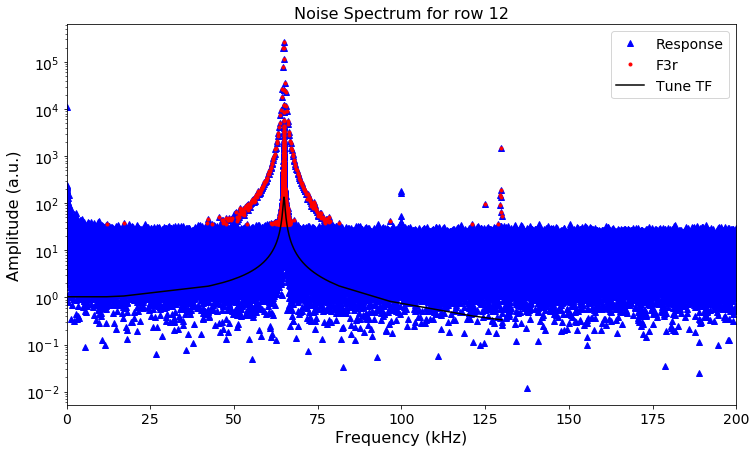

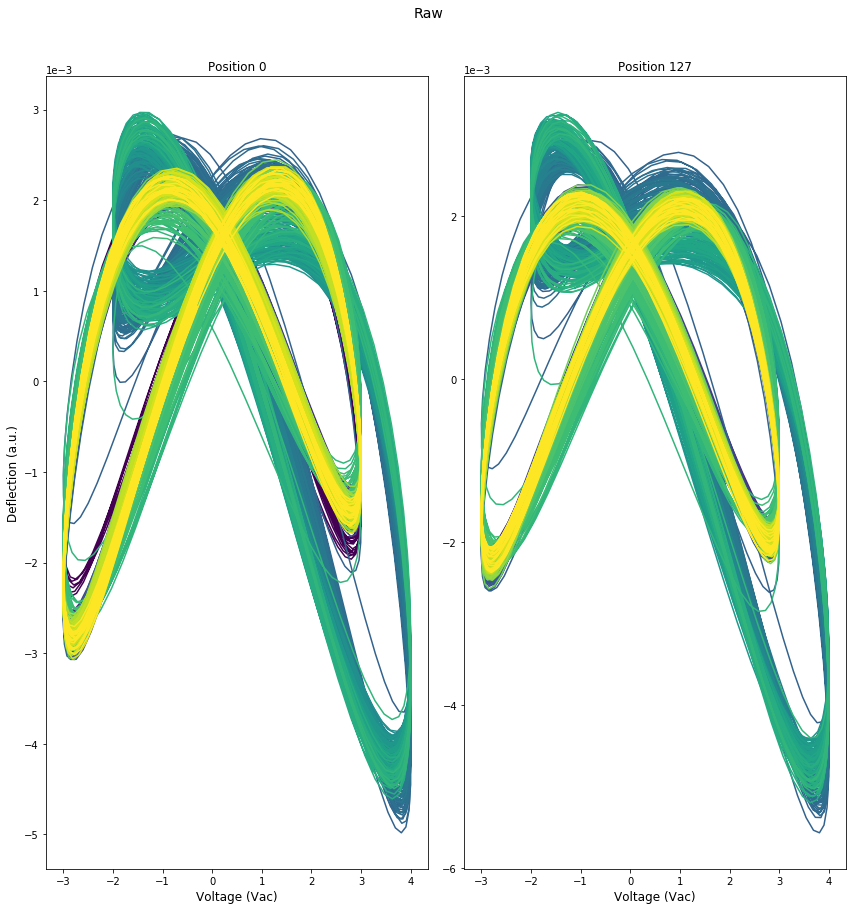

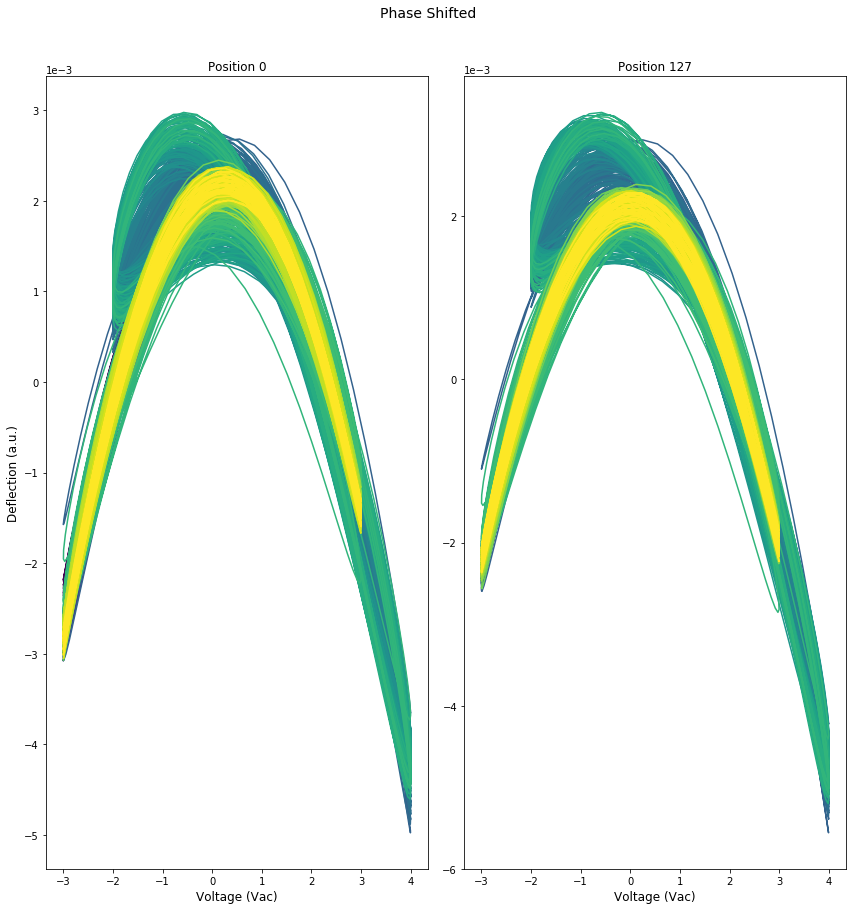

In [69]:
fig, ax = plt.subplots(figsize=(12, 7))
plt.semilogy(w_vec, (np.abs(FRaw_resp)), '^b' ,label='Response')
#plt.semilogy(w_vec[signal_ind_vec], (np.abs(G[signal_ind_vec])), 'og')
plt.semilogy(w_vec[signal_ind_vec], (np.abs(FRaw_resp[signal_ind_vec])),'.r', label='F3r')
plt.semilogy(w_vec[signal_ind_vec], np.abs(TF_norm[signal_ind_vec]), 'k', label='Tune TF')
ax.set_xlabel('Frequency (kHz)', fontsize=16)
ax.set_ylabel('Amplitude (a.u.)', fontsize=16)
ax.legend(fontsize=14)
ax.set_yscale('log')
ax.set_xlim(0, 200)
ax.set_title('Noise Spectrum for row ' + str(row_ind), fontsize=16)
usid.plot_utils.set_tick_font_size(ax, 14)

# In time domain again, compare pre/post-phase-shift-corrected versions
unshifted = G_time_line.reshape(-1, pixel_ex_wfm.size)
phaseshifted = G_wPhase_time_line.reshape(-1, pixel_ex_wfm.size)

# Unshifted phase, pre-FFT filter
raw = np.real(np.fft.ifft(np.fft.ifftshift(FRaw_resp)))
raw = raw.reshape(-1, pixel_ex_wfm.size)

#fig, axes = px.plot_utils.plot_loops(pixel_ex_wfm, raw, use_rainbow_plots=True, 
#                                     x_label='Voltage (Vac)', title='Raw',
#                                     plots_on_side=2, y_label='Deflection (a.u.)')


# Unshifted phases, post-FFT filter
fig, axes = usid.plot_utils.plot_curves(pixel_ex_wfm, unshifted, use_rainbow_plots=True, 
                                     x_label='Voltage (Vac)', title='Raw',
                                     num_plots=2, y_label='Deflection (a.u.)')

# Shifted phase; ideally parabolas should overlap
fig, axes = usid.plot_utils.plot_curves(pixel_ex_wfm, phaseshifted, use_rainbow_plots=True, 
                                     x_label='Voltage (Vac)', title='Phase Shifted',
                                     num_plots=2, y_label='Deflection (a.u.)')

fig.savefig(output_filepath+r'\PostFilter_Displacements.tif', format='tiff')

#### Filter the full data set 
###### **(this process is quite slow!)**

In [70]:
h5_filt_grp = usid.hdf_utils.check_for_old(h5_main, 'FFT_Filtering')#, new_parms=filter_parms)

if not h5_filt_grp:
    
    sig_filt = px.processing.SignalFilter(h5_main, frequency_filters=freq_filts, 
                                          noise_threshold=noise_tolerance,
                                          write_filtered=True, write_condensed=False, 
                                          num_pix=1,verbose=True, cores=1, max_mem_mb=512)
    h5_filt_grp = sig_filt.compute()
    
else:
    print('Taking previously computed results')

if isinstance(h5_filt_grp, list):
    h5_filt = h5_filt_grp[0]['Filtered_Data']
else:
    h5_filt = h5_filt_grp['Filtered_Data']

# Reshapes the filtered response into a matrix per-pixel instead of in lines (as recorded by NI box)

print('\n','#### Done! Now reshaping... ####')
h5_main_filt = usid.hdf_utils.find_dataset(hdf.file,'Filtered_Data')[0]

scan_width=1
h5_resh = px.processing.gmode_utils.reshape_from_lines_to_pixels(h5_filt, pixel_ex_wfm.size,
                                                                 scan_width / num_cols)
h5_resh_grp = h5_resh.parent
h5_resh.shape

No mpi4py found or script was not called via mpixexec / mpirun. Assuming single node computation
Rank 0: Upgrading from a regular h5py.Dataset to a USIDataset
Rank 0: The HDF5 dataset is now a USIDataset
Rank 0 - on socket with 4 cores and 964.7 MB avail. RAM shared by 1 ranks each given 1 cores.
User has requested to use no more than 512.0 MB of memory.
Rank 0: Each of the 1 workers on this socket are allowed to use 512.0 MB of RAM.
Each position in the SOURCE dataset is 8.0 MB large.
Rank 0: Workers on this socket allowed to read 64 positions of the SOURCE dataset only per chunk.
Finished collecting info on memory and workers
Consider calling test() to check results before calling compute() which computes on the entire dataset and writes back to the HDF5 file
Allowed to read 21 pixels per chunk
Checking for duplicates:
Creating HDF5 group and datasets to hold results
Rank 0 - Finished creating the Composite_Filter dataset
Rank 0 - Reusing source datasets position datasets
h5 group an

(8192, 32768)

#### PCA on the filtered response

Consider calling test() to check results before calling compute() which computes on the entire dataset and writes back to the HDF5 file
Took 1.68 mins to compute randomized SVD
Need 1 components for 80%
Need 2 components for 90%
Need 25 components for 95%


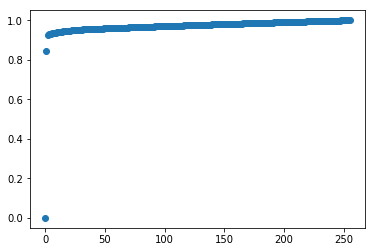

In [72]:
h5_svd = px.processing.svd_utils.SVD(h5_resh, num_components=256)
h5_svd_group = h5_svd.compute()

h5_Uprecon = h5_svd_group['U']
h5_Vprecon = h5_svd_group['V']
h5_Sprecon = h5_svd_group['S']

skree_sum = np.zeros(h5_Sprecon.shape)

for i in range(h5_Sprecon.shape[0]):
    skree_sum[i] = np.sum(h5_Sprecon[:i])/np.sum(h5_Sprecon)

plt.figure()
plt.plot(skree_sum, 'o')
print('Need', skree_sum[skree_sum<0.8].shape[0],'components for 80%')
print('Need', skree_sum[skree_sum<0.9].shape[0],'components for 90%')
print('Need', skree_sum[skree_sum<0.95].shape[0],'components for 95%')

# Since the two spatial dimensions (x, y) have been collapsed to one, we need to reshape the abundance maps:
# The "25" is how many of the eigenvectors to keep
abun_maps = np.reshape(h5_Uprecon[:,:25], (num_rows, num_cols,-1))

##### Visualize PCA prior to F3R

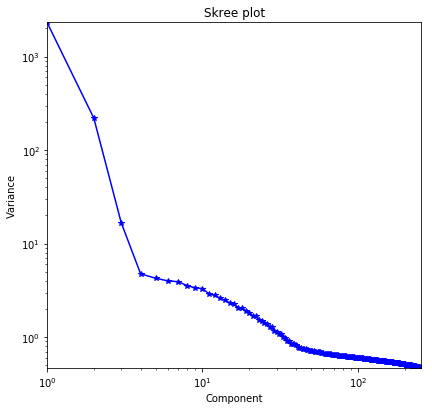

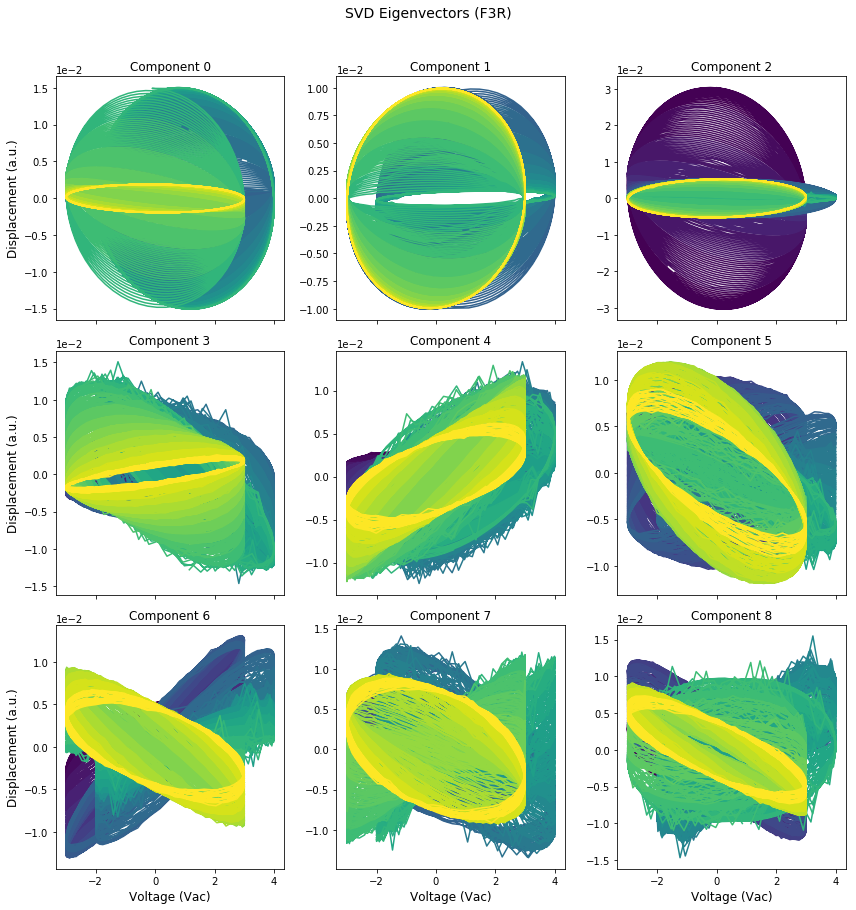

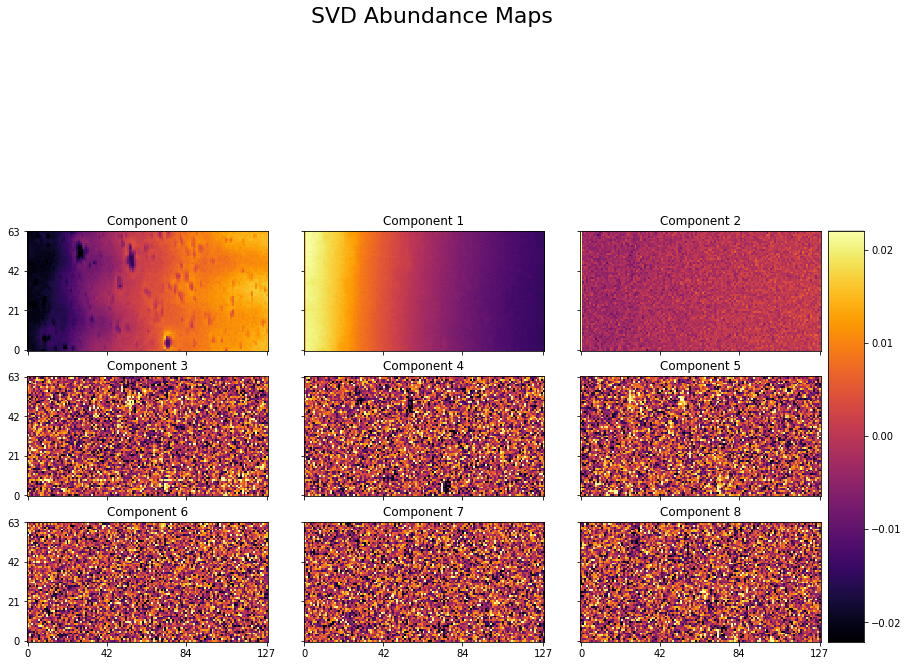

In [73]:
fig, axes = usid.plot_utils.plot_scree(h5_Sprecon, title='Skree plot')

if save_figure == True:
    fig.savefig(output_filepath+'\PCARaw_Skree.eps', format='eps')
    fig.savefig(output_filepath+'\PCARaw_Skree.tif', format='tiff')

# Visualize the eigenvectors; 
first_evecs = h5_Vprecon[:9, :]

fig, axes = usid.plot_utils.plot_curves(pixel_ex_wfm, first_evecs, use_rainbow_plots=True, 
                                        x_label='Voltage (Vac)', y_label='Displacement (a.u.)', 
                                        num_plots=9, subtitle_prefix='Component', 
                                        title='SVD Eigenvectors (F3R)', evenly_spaced=False)

if save_figure == True:
    fig.savefig(output_filepath+'\PCARaw_Eig.eps', format='eps')
    fig.savefig(output_filepath+'\PCARaw_Eig.tif', format='tiff')

# Visualize the abundance maps:
fig, axes = usid.plot_utils.plot_map_stack(abun_maps, num_comps=9, title='SVD Abundance Maps',
                                            color_bar_mode='single', cmap='inferno', reverse_dims=True)

if save_figure == True:
    fig.savefig(output_filepath+r'\PCARaw_Loading.eps', format='eps')
    fig.savefig(output_filepath+r'\PCARaw_Loading.tif', format='tiff')

#### Optionally Clean Data
Here, we are looking primarily to capture the most variance without capturing noise. In this case, the Skree plot is a good visual indication of where to filter up to. Also, some components might contribute to variance but be noise-- instrument noise, for example. 

As a precaution, you should try and be a little conservative as aggressive PCA filtering will ultimately change your data.

In [75]:
''' 
Performs PCA filtering prior to F3R Step

To avoid constantly redoing SVD, this segment also checks the components_used attribute to see if the SVD rebuilt has been
done with these components before. 

clean_components can either be:
    -a single component; [0]
    -a range; [0,2] is same as [0,1,2]
    -a subset of components; [0,1,4,5] would not include 2,3, and 6-end 
'''

PCA_pre_reconstruction_clean = True

# Filters out the components specified from h5_resh (the reshaped h5 data)
if PCA_pre_reconstruction_clean == True:
    
    # important! If choosing components, min is 3 or interprets as start/stop range of slice
    clean_components = np.array([0,1,2,3]) # np.append(range(5,9),(17,18))

    # checks for existing SVD
    itms = [i for i in h5_resh.parent.items()]
    svdnames = []
    for i in itms:
        if 'Reshaped_Data-SVD' in i[0]:
            svdnames.append(i[1])
    
    SVD_exists = False
    for i in svdnames:
        print(i.name.split('/')[-1])
        if usid.hdf_utils.find_dataset(hdf.file[i.name], 'Rebuilt_Data') != []:
            rb = usid.hdf_utils.find_dataset(hdf.file[i.name], 'Rebuilt_Data')[0]
            if np.array_equal(rb.parent.attrs['components_used'], clean_components):
                print(i.name.split('/')[-1],'has same components')
                SVD_exists = True
                test = rb
    
    if SVD_exists == False:
        print('#### Doing SVD ####')
        test = px.processing.svd_utils.rebuild_svd(h5_resh, components=clean_components)
    
    PCA_clean_data_prerecon = test[:,:].reshape(num_rows,-1)

Reshaped_Data-SVD_000
#### Doing SVD ####
Reconstructing in batches of 2048 positions.
Batchs should be 512.03125 Mb each.
Completed reconstruction of data from SVD results.  Writing to file.
Done writing reconstructed data to file.


## Step 3) Fast Free Force Reconstruction

### Step 3A) Divide Filtered displacement Y(w) by effective transfer function H(w)
This process takes awhile. A few minutes is normal.

In [76]:
# Divide Image-data h5_main by Tune-data TF_norm
ind_drive = (np.abs(w_vec2-ex_freq)).argmin()

G = np.zeros(w_vec2.size,dtype=complex)
G_time = np.zeros(shape=h5_filt.shape, dtype=h5_filt.dtype)

signal_ind_vec = np.arange(w_vec2.size)

NoiseLimit = np.ceil(noise_floor)

for i in range(num_rows):

    if (i%10 == 0)
        print('Row', i)
        
    signal_ind_vec=np.arange(w_vec2.size)
      
    G = np.zeros(w_vec2.size,dtype=complex)         # G = raw
    
    # Step 3B) Phase correction; ph value is defined way above in Step 2B.i
    if PCA_pre_reconstruction_clean == True:
        test_data = PCA_clean_data_prerecon[i,:] - np.mean(PCA_clean_data_prerecon[i,:])   
    else:
        test_data = h5_filt[i,:] - np.mean(h5_filt[i,:])
    
    # filt_line is from filtered data above  
    test_data = np.fft.fftshift(np.fft.fft(test_data))
    signal_kill = np.where(np.abs(test_data) < NoiseLimit)
    signal_ind_vec = np.delete(signal_ind_vec,signal_kill)
    test_data_ph = (test_data) * np.exp(-1j*w_vec2/(w_vec2[ind_drive])*ph)

    # Step 3C)  iFFT the response above a user defined noise floor to recover Force in time domain.
    G[signal_ind_vec] = test_data_ph[signal_ind_vec]
    G = G/TF_norm
    G_time[i,:] = np.real(np.fft.ifft(np.fft.ifftshift(G)))

    FRaw_resp = np.fft.fftshift(np.fft.fft(h5_main[i]))

# Saves as backup in Python for later analysis; can remove from this notebook if you'd like
if PCA_pre_reconstruction_clean == False:
    G_time_noPCA = np.copy(G_time)
else:
    G_time_PCA = np.copy(G_time)

#### Check a row to validate results

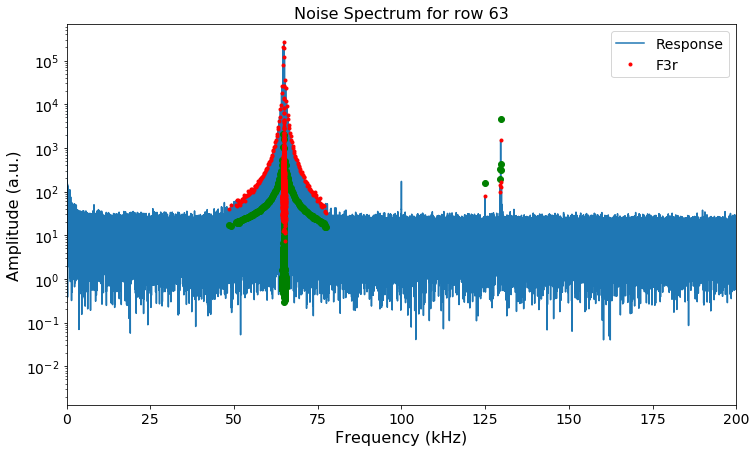

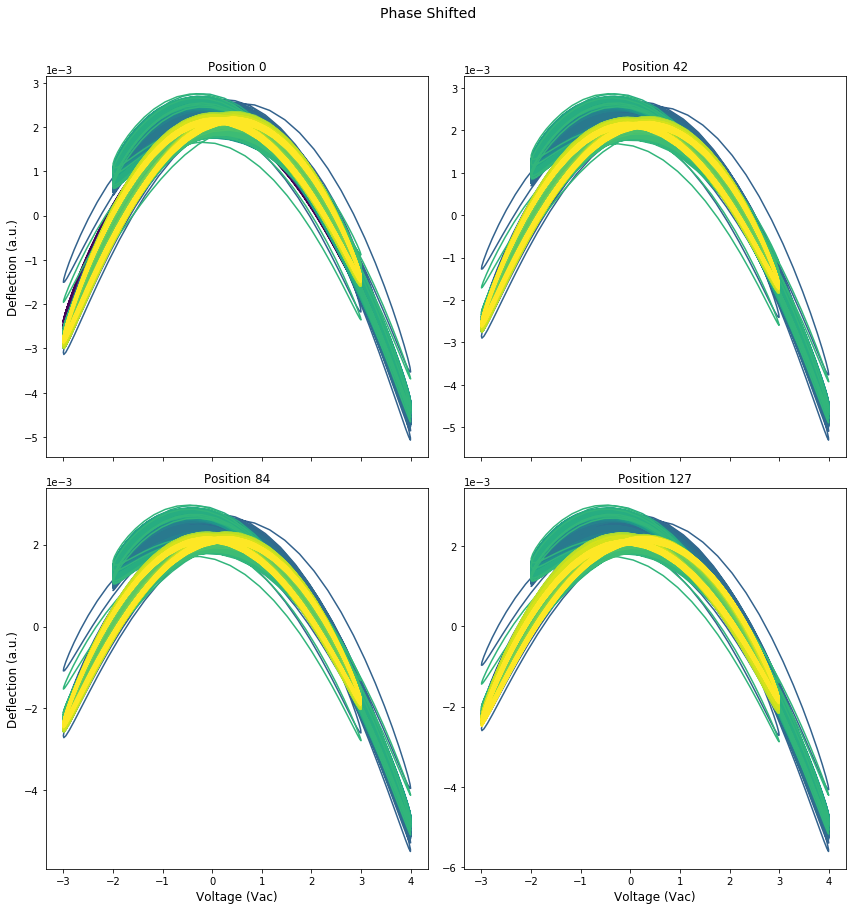

In [80]:
fig, ax = plt.subplots(figsize=(12, 7))
plt.semilogy(w_vec, (np.abs(FRaw_resp)), label='Response')
plt.semilogy(w_vec[signal_ind_vec], (np.abs(G[signal_ind_vec])), 'og')
plt.semilogy(w_vec[signal_ind_vec], (np.abs(FRaw_resp[signal_ind_vec])),'.r', label='F3r')
ax.set_xlabel('Frequency (kHz)', fontsize=16)
ax.set_ylabel('Amplitude (a.u.)', fontsize=16)
ax.legend(fontsize=14)
ax.set_yscale('log')
ax.set_xlim(0, 200)
ax.set_title('Noise Spectrum for row ' + str(i), fontsize=16)
usid.plot_utils.set_tick_font_size(ax, 14)

if save_figure == True:
    if PCA_pre_reconstruction_clean == False:
        fig.savefig(output_filepath+r'\Noise_Spectra_noprePCA.eps', format='eps')
        fig.savefig(output_filepath+r'\Noise_Spectra_noprePCA.tif', format='tiff')
    else:
        fig.savefig(output_filepath+r'\Noise_Spectra_prePCA.eps', format='eps')
        fig.savefig(output_filepath+r'\Noise_Spectra_prePCA.tif', format='tiff')        

phaseshifted = G_time[i].reshape(-1, pixel_ex_wfm.size)
fig, axes = usid.plot_utils.plot_curves(pixel_ex_wfm, phaseshifted, use_rainbow_plots=True, 
                                     x_label='Voltage (Vac)', title='Phase Shifted',
                                     num_plots=4, y_label='Deflection (a.u.)')

if PCA_pre_reconstruction_clean == False:
    fig.savefig(output_filepath+r'\PostFilter_Displacement_noprePCA.tif', format='tiff')
else:
    fig.savefig(output_filepath+r'\PostFilter_Displacement_prePCA_['+str(clean_components)+'].tif', format='tiff')

#### Reshaping and Storing  Results

In [83]:
# copies h5_filt over to H5_F3R; if necessary can come back here to reprocess
h5_F3R = usid.hdf_utils.create_empty_dataset(source_dset=h5_filt,
                                           dtype=h5_filt.dtype,
                                           dset_name='h5_F3R',
                                           new_attrs=dict(),
                                           skip_refs=False)
usid.hdf_utils.copy_main_attributes(h5_filt, h5_F3R)
h5_F3R[:,:] = G_time[:,:]
h5_F3R.file.flush()

usid.hdf_utils.link_as_main(h5_main=h5_F3R, h5_pos_inds=h5_pos_inds,
                          h5_pos_vals=h5_pos_vals, h5_spec_inds=h5_spec_inds,
                          h5_spec_vals=h5_spec_vals)

h5_F3Rresh_grp = usid.hdf_utils.find_results_groups(h5_F3R, 'Reshape')

scan_width = 1
h5_F3Rresh = px.processing.gmode_utils.reshape_from_lines_to_pixels(h5_F3R, pixel_ex_wfm.size, scan_width / num_cols)
h5_F3Rresh_grp = h5_F3Rresh.parent

# Saves whether it was PCA cleaned before or not
if PCA_pre_reconstruction_clean == True:
    h5_F3Rresh_grp.attrs['pre_PCA'] = clean_components
else:
    h5_F3Rresh_grp.attrs['pre_PCA'] = -1

print('Data was reshaped from shape', h5_F3R.shape,
      'reshaped to ', h5_F3Rresh.shape)

# Sanity check that our reshape works. Since this is usually the case this is commented out for now
#raw = np.reshape(h5_F3Rresh, [-1, pixel_ex_wfm.size])
#fig, axes = px.plot_utils.plot_curves(pixel_ex_wfm, raw[128:256],use_rainbow_plots=True, 
#                                     x_label='Voltage (Vac)', title='Raw',
#                                     num_plots=4, y_label='Deflection (a.u.)')

Starting to reshape G-mode line data. Please be patient
Finished reshaping G-mode line data to rows and columns
Data was reshaped from shape (64, 4194304) reshaped to  (8192, 32768)


#### Do PCA on F3R recovered data

In [84]:
# SVD and save results
h5_svd = px.processing.svd_utils.SVD(h5_F3Rresh, num_components=256)
h5_svd_group = h5_svd.compute()

h5_U = h5_svd_group['U']
h5_V = h5_svd_group['V']
h5_S = h5_svd_group['S']

# Since the two spatial dimensions (x, y) have been collapsed to one, we need to reshape the abundance maps:
abun_maps_postfilter = np.reshape(h5_U[:,:25], (num_rows, num_cols,-1))

Consider calling test() to check results before calling compute() which computes on the entire dataset and writes back to the HDF5 file
Took 2.21 mins to compute randomized SVD


#### Visualize PCA on F3R Data

Need 1 components for 80%
Need 1 components for 90%
Need 2 components for 95%
Need 4 components for 99%


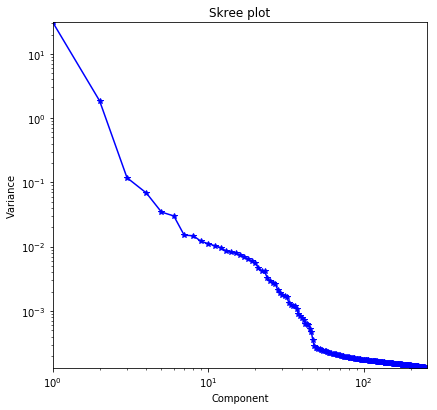

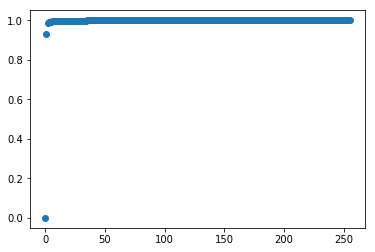

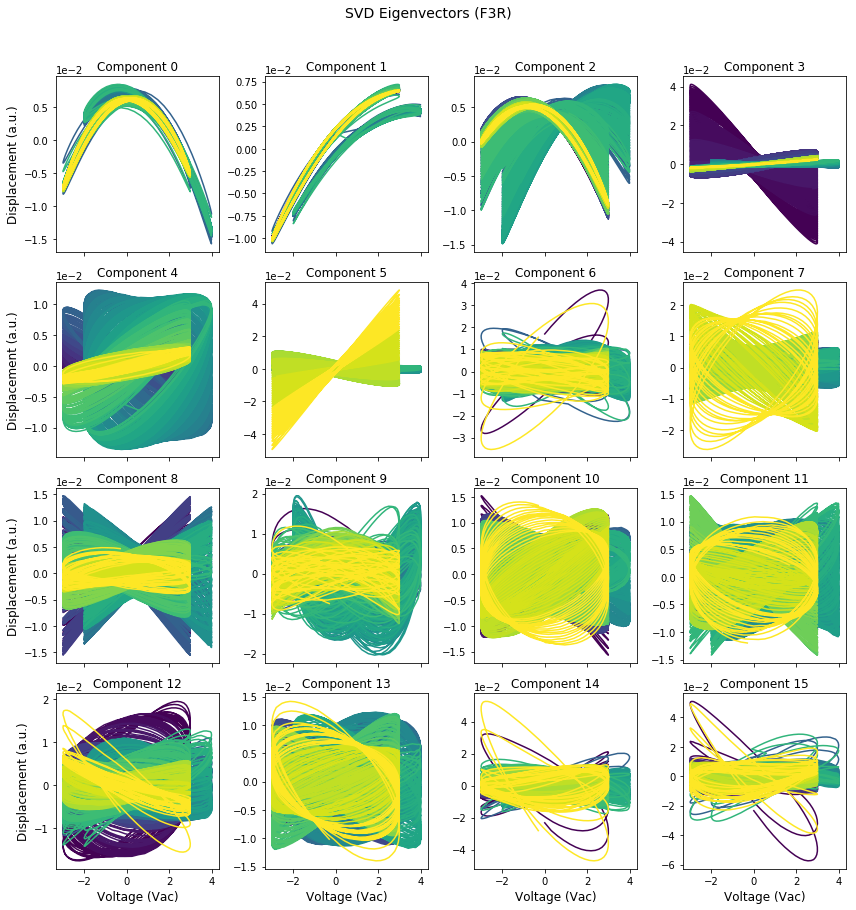

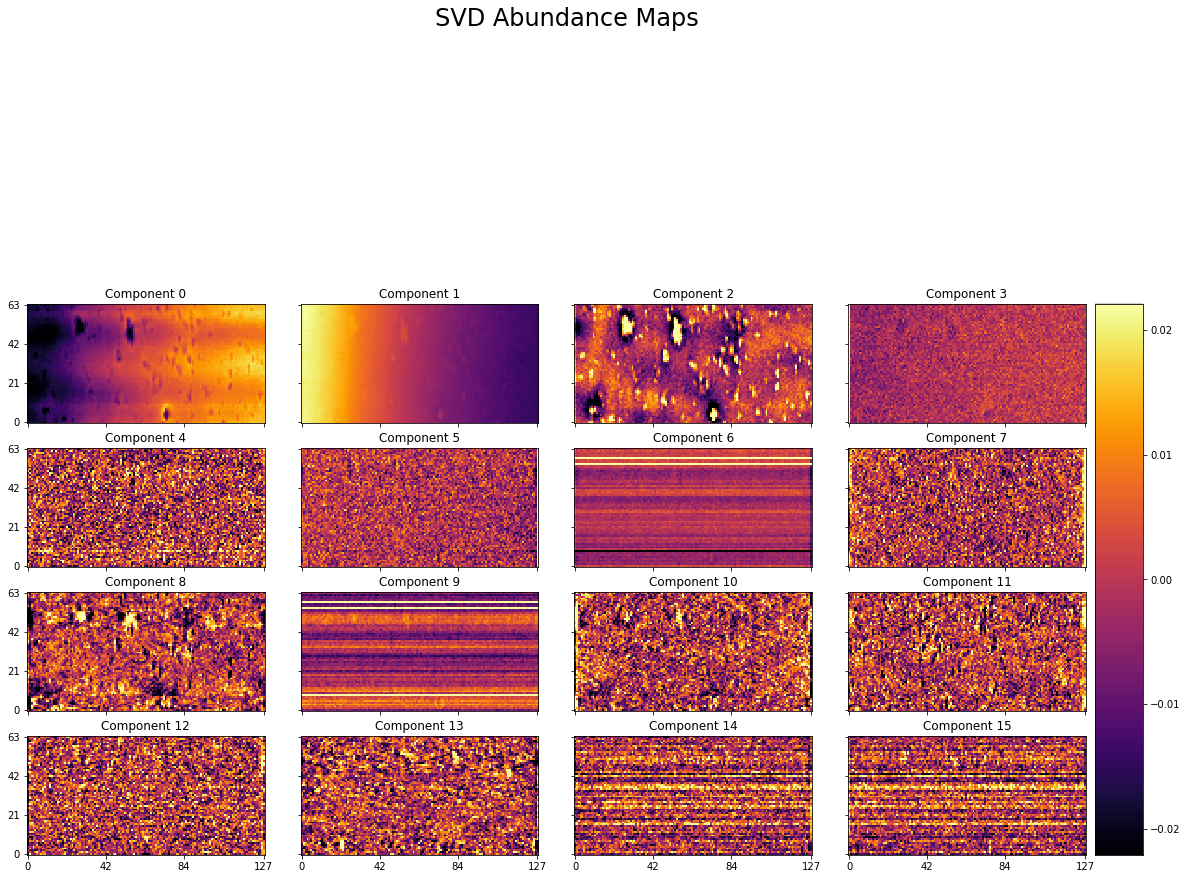

In [86]:
fig, axes = usid.plot_utils.plot_scree(h5_S, title='Skree plot')

if save_figure == True:
    if PCA_pre_reconstruction_clean == False:
        fig.savefig(output_filepath+'\PCF3R_Skree_noPrePCa.tif', format='tiff')
    else:
        fig.savefig(output_filepath+'\PCF3R_Skree_withPrePCA.tif', format='tiff')

skree_sum = np.zeros(h5_S.shape)

for i in range(h5_S.shape[0]):
    skree_sum[i] = np.sum(h5_S[:i])/np.sum(h5_S)

plt.figure()
plt.plot(skree_sum, 'o')
print('Need', skree_sum[skree_sum<0.8].shape[0],'components for 80%')
print('Need', skree_sum[skree_sum<0.9].shape[0],'components for 90%')
print('Need', skree_sum[skree_sum<0.95].shape[0],'components for 95%')
print('Need', skree_sum[skree_sum<0.99].shape[0],'components for 99%')

# Visualize the eigenvectors:
first_evecs = h5_V[:16, :]

fig, axes = usid.plot_utils.plot_curves(pixel_ex_wfm, first_evecs, x_label='Voltage (Vac)', use_rainbow_plots=True, 
                                    y_label='Displacement (a.u.)', num_plots=16,
                                    subtitle_prefix='Component', title='SVD Eigenvectors (F3R)', evenly_spaced=False)

if save_figure == True:
    if PCA_pre_reconstruction_clean == False:
        fig.savefig(output_filepath+'\PCAF3R_Eig_noPrePCA.eps', format='eps')
        fig.savefig(output_filepath+'\PCF3R_Eig_noPrePCA.tif', format='tiff')
    else:
        fig.savefig(output_filepath+'\PCAF3R_Eig_withPrePCA.eps', format='eps')
        fig.savefig(output_filepath+'\PCF3R_Eig_withPrePCA.tif', format='tiff')

# Visualize the abundance maps:
fig, axes = usid.plot_utils.plot_map_stack(abun_maps_postfilter, num_comps=16, title='SVD Abundance Maps',
                             color_bar_mode='single', cmap='inferno', reverse_dims=True)
if save_figure == True:
    if PCA_pre_reconstruction_clean == False:
        fig.savefig(output_filepath+'\PCAF3R_Loadings_noPrePCA.eps', format='eps')
        fig.savefig(output_filepath+'\PCF3R_Loadings_noPrePCA.tif', format='tiff')
    else:
        fig.savefig(output_filepath+'\PCAF3R_Loadings_withPrePCA.eps', format='eps')
        fig.savefig(output_filepath+'\PCF3R_Loadings_withPrePCA.tif', format='tiff')

#### Optionally Clean Data
Here, we are looking primarily to capture the most variance without capturing noise. If you used PCA filtering before, the chances are high that most of the variance is in the first 1-2 components. 

Include too few components, though, and the CPDs will all look mostly identical (depends on your data).

In [87]:
''' 
As before, we check to make sure we aren't doing SVD over and over again with same components during the debugging phase.
'''

PCA_post_reconstruction_clean = False

if PCA_post_reconstruction_clean == True:
    clean_components = np.array([0,1,2,3,5,7]) ##Components you want to keep
    #num_components = len(clean_components)
    
    # checks for existing SVD
    rebuilt_grp = h5_F3Rresh.parent.name + '/Reshaped_Data-SVD_000'
    names = h5_list(hdf.file[rebuilt_grp],'Rebuilt_Data')
    
    # Checks if SVD has been done somewhere with these components already to save time
    SVD_exists = False
    for i in names:
        rb = hdf.file[rebuilt_grp+'/'+i]
        print(i,rb.attrs['components_used'])
        if np.array_equal(rb.attrs['components_used'],clean_components):
            print(i,'has same components')
            SVD_exists = True
            test = rb['Rebuilt_Data']
            
    if SVD_exists == False:
        test = px.processing.svd_utils.rebuild_svd(h5_F3Rresh, components=clean_components)
        
    PCA_clean_data_postrecon = test[:,:].reshape(num_rows*num_cols,-1)

### Test fitting on sample data

Time resolution: 6.159398496240601e-05
Not post-filtered
0.22934478334924224  V for CPD
0.5737753964968406  ms for ON
0.36553380146931913  ms for OFF
0.5716113060396533  ms for ON
0.3466770399313745  ms for OFF
0.573556949948167  ms for ON
0.31714398247758735  ms for OFF


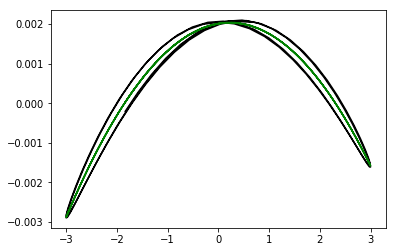

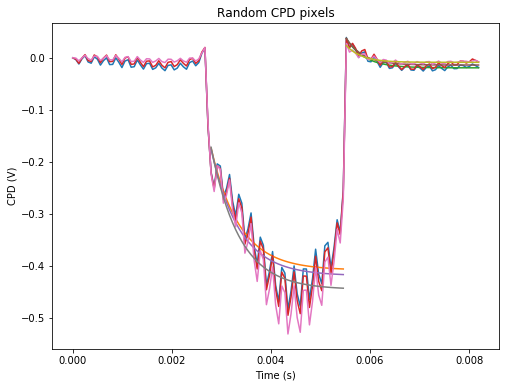

In [91]:
# This is number of periods you want to average over,
# for best time resolution =1 (but takes much longer to fit)
periods = 4
num_periods_per_sample = int(np.floor(num_periods / periods))
pnts_per_sample = int(np.floor(pnts_per_period * periods))

light_on_time = [2.8, 5.5]

complete_periods = True

'''
We can maximize the number of points by using "incomplete" periods per cycle, 
since number of cycles will not fit exactly into the acquired dataset
'''
if complete_periods == False:

    decimation = 2**int(np.floor(np.log2(pnts_per_sample)))
    pnts_per_CPDpix = int(N_points_per_pixel/decimation)
    remainder = 0
else:
    # old approach, but add section for missing period at the end
    decimation = int(np.floor(pnts_per_sample))
    pnts_per_CPDpix = int(N_points_per_pixel/decimation)
    remainder = N_points_per_pixel - pnts_per_CPDpix*decimation

print('Time resolution:',pxl_time/pnts_per_CPDpix)

# time scale for plotting
tx = np.linspace(0, pxl_time, pnts_per_CPDpix) 

deg = 2
row = 3*num_cols+14  #random sample pixel

p = 3 #random oscillation in that pixel
# note k4 cannot exceed Npoints_per_pixel/periods, obviously

##Raw F3R response
# Use PCA clean or not
if PCA_post_reconstruction_clean == False:
    print('Not post-filtered')
    resp = np.float32(h5_F3Rresh[row][pnts_per_CPDpix*p:pnts_per_CPDpix*(p+1)])
else:
    resp = np.float32(PCA_clean_data_postrecon[row][pnts_per_CPDpix*p:pnts_per_CPDpix*(p+1)])

resp = resp-np.mean(resp)
V_per_osc = pixel_ex_wfm[pnts_per_CPDpix*p:pnts_per_CPDpix*(p+1)]

p1,s = npPoly.polyfit(V_per_osc,resp,deg,full=True)
y1 = npPoly.polyval(V_per_osc,p1)
print(-0.5*p1[1]/p1[2], ' V for CPD')

plt.figure()
plt.plot(V_per_osc,resp, 'k')
plt.plot(V_per_osc,y1, 'g')

test_wH = np.zeros((pnts_per_CPDpix, deg+1))

# Tests plotting a few random CPDS from some subset of pixels
# This does not test for actual number of rows/columns available
rows = [1*num_cols+14, 44*num_cols+16, 32*num_cols+67]  
fig,a = plt.subplots(nrows=1, figsize=(8,6))
a.set_xlabel('Time (s)')
a.set_ylabel('CPD (V)')
a.set_title('Random CPD pixels')

# For testing CPD fits; these are pixel values for "light on" and "light off" time
p_on = int(light_on_time[0]*1e-3 * pnts_per_CPDpix/pxl_time) 
p_off = int(light_on_time[1]*1e-3 * pnts_per_CPDpix/pxl_time) 

time = np.linspace(0, pxl_time, pnts_per_CPDpix)
time_on = time[p_on:p_off]
time_off = time[p_off:]   

# Curve fitting limits. 
bds_on = ([-10, (1e-5), -5, time_on[0]-1e-10], 
          [10, (1e-1), 5, time_on[0]+1e-10])  
bds_off = ([-10, (1e-5), -5, time_off[0]-1e-10], 
           [10, (1e-1), 5, time_off[0]+1e-10])  

plot_fits = True
for row in rows:
    for p in range(pnts_per_CPDpix-min(1,remainder)):
    
        if PCA_post_reconstruction_clean == False:
            resp = np.float32(h5_F3Rresh[row][decimation*p:decimation*(p+1)])
        else:
            resp = np.float32(PCA_clean_data_postrecon[row][decimation*p:decimation*(p+1)])
                
        resp = (resp-np.mean(resp))
        V_per_osc = pixel_ex_wfm[decimation*p:decimation*(p+1)]
        popt, _ = npPoly.polyfit(V_per_osc, resp, deg, full=True)
        test_wH[p] = popt
    
    # if using complete periods approach, then last point will be cycle+leftover
    if remainder > 0:
        if PCA_post_reconstruction_clean == False:
            resp = np.float32(h5_F3Rresh[row][(pnts_per_CPDpix-1)*decimation:])
        else:
            resp = np.float32(PCA_clean_data_postrecon[row][(pnts_per_CPDpix-1)*decimation:])
       
        resp = (resp-np.mean(resp))
        V_per_osc = pixel_ex_wfm[(pnts_per_CPDpix-1)*decimation:]
        popt, _ = npPoly.polyfit(V_per_osc, resp, deg, full=True)
        
        test_wH[-1,:] = popt
    
    if plot_fits == True:    
        test_CPD = -0.5 * test_wH[:,1]/test_wH[:,2]
        [cuton, cutoff] = [test_CPD[p_on:p_off] - test_CPD[0], test_CPD[p_off:] - test_CPD[0]]
        popt1, _ = curve_fit(fitexp, time_on, cuton, bounds=bds_on)
        popt2, _ = curve_fit(fitexp, time_off, cutoff, bounds=bds_off)
        a.plot(tx, test_CPD-test_CPD[0], time_on, fitexp(time_on, *popt1), time_off, fitexp(time_off, *popt2))
        print(popt1[1]*1e3,' ms for ON')
        print(popt2[1]*1e3,' ms for OFF')
    else:
        a.plot(tx, test_CPD-test_CPD[0])

# Save results
prerecon = 'PrePCA' if PCA_pre_reconstruction_clean == True else ''
if PCA_post_reconstruction_clean == True:
    fig.savefig(output_filepath+'\RandomCPDs_'+prerecon+'PCA'+str(clean_components)
                +'_'+str(periods)+'periods.tif', format='tiff')
else:
    fig.savefig(output_filepath+'\RandomCPDs_'+prerecon+'noPCA_'+str(periods)+'periods.tif', format='tiff')


### Repeat on the full dataset
This is very slow! Probably 2-4x as long as generating F3R

In [92]:
# Uses the periods settings up above. Uncomment the following lines if you want to jump right here.
#periods = 4
#complete_periods = True
 
num_periods_per_sample = int(np.floor(num_periods / periods))
pnts_per_sample = int(np.floor(pnts_per_period * periods))

if complete_periods == False:
    # new approach since it's base-2 samples and can curve-fit to less than full cycle
    decimation = 2**int(np.floor(np.log2(pnts_per_sample)))
    pnts_per_CPDpix = int(N_points_per_pixel/decimation)
    remainder = 0
else:
    # old approach, but add section for missing period at the end
    decimation = int(np.floor(pnts_per_sample))
    pnts_per_CPDpix = int(N_points_per_pixel/decimation)
    remainder = N_points_per_pixel - pnts_per_CPDpix*decimation

# time scale for plotting
tx = np.linspace(0, pxl_time, pnts_per_CPDpix) 

deg = 2 #parabola
wHfit3 = np.zeros((num_rows*num_cols, pnts_per_CPDpix, deg+1))

print('#### Generating CPD from F3R ####')
for n in range((num_rows*num_cols)):

    # Just for updating you this is in progress..
    if n%1000 == 0:
        print('Pixel: ', n)
        
    for p in range(pnts_per_CPDpix-min(1,remainder)): 

        if PCA_post_reconstruction_clean == False:
            resp = np.float32(h5_F3Rresh[n][decimation*p:decimation*(p+1)])
        else:
            resp = np.float32(PCA_clean_data_postrecon[n][decimation*p:decimation*(p+1)])
                
        resp = resp-np.mean(resp)
        V_per_osc = pixel_ex_wfm[decimation*p:decimation*(p+1)]
        popt, _ = npPoly.polyfit(V_per_osc, resp, deg, full=True)
        wHfit3[n,p,:] = popt
        
    # if using complete periods approach, then last point will be cycle+leftover
    if remainder > 0:
        if PCA_post_reconstruction_clean == False:
            resp = np.float32(h5_F3Rresh[n][(pnts_per_CPDpix-1)*decimation:])
        else:
            resp = np.float32(PCA_clean_data_postrecon[n][(pnts_per_CPDpix-1)*decimation:])
       
        resp = (resp-np.mean(resp))
        V_per_osc = pixel_ex_wfm[(pnts_per_CPDpix-1)*decimation:]
        popt, _ = npPoly.polyfit(V_per_osc, resp, deg, full=True)
        
        wHfit3[n,-1,:] = popt
    
# polyfit returns a + bx + cx^2 coefficients
        

    


#### Generating CPD from F3R ####
Pixel:  0
Pixel:  1000
Pixel:  2000
Pixel:  3000
Pixel:  4000
Pixel:  5000
Pixel:  6000
Pixel:  7000
Pixel:  8000


In [110]:
# lets us debug further; cap is just capacitance (curvature), CPD is from peak of parabola
if PCA_post_reconstruction_clean == True:

    CPD_PCA = -0.5*np.divide(wHfit3[:,:,1],wHfit3[:,:,2]) # vertex of parabola
    CPD_PCA_cap = wHfit3[:,:,2]
    CPD = np.copy(CPD_PCA[:,:])
    CPD_grad = np.copy(CPD_PCA_cap[:,:])
    CPD_PCA_offset = wHfit3[:,:,0]
    CPD_offset = np.copy(CPD_PCA_offset)
    
else:
    
    CPD_raw = -0.5*np.divide(wHfit3[:,:,1],wHfit3[:,:,2])
    CPD_raw_cap = wHfit3[:,:,2]
    CPD = np.copy(CPD_raw[:,:])
    CPD_grad = np.copy(CPD_raw_cap[:,:])
    CPD_raw_offset = wHfit3[:,:,0]
    CPD_offset = np.copy(CPD_raw_offset)

## Store to H5

In [94]:
# Saves the CPD to the H5 file
e = h5_main.parent.name + '/' + 'Raw_Data-CPD'

if e in hdf.file:
    print('Overwriting CPD dataset')
    grp_name = hdf.file[e]
    del grp_name['CPD']
    grp_name['CPD'] = CPD[:,:]
    
    print(np.allclose(grp_name['CPD'].value, CPD))
    
else:    
    print('Creating new dataset')
    grp_CPD = usid.hdf_utils.create_indexed_group(h5_main.parent, 'CPD')
    CPD_spec_dims = [usid.write_utils.Dimension('Time', 's', tx)]
    h5_CPD = usid.hdf_utils.write_main_dataset(grp_CPD,
                                             CPD,
                                             'CPD',
                                             'CPD',
                                             'V',
                                             pos_dims,
                                             CPD_spec_dims)

Creating new dataset


In [95]:
# Writes the parabola to H5 file    
try:
    dset = hdf.file.create_dataset("parafit_main", shape=wHfit3.shape, dtype=np.float32)
    dset[:,:] = wHfit3
except:
    print('Overwriting Parabola Fit Save')
    dset = hdf.file['parafit_main']
    dset = wHfit3
    
hdf.file.flush()

#### (Optional) Reconstruct CPD from parabola fit data (when loading an old) file

In [107]:
#%% Reconstruct CPD from parafit these data
reconstruct = False

# dset is NxP, N = num_pixels total, P= number of points per CPD trace (8192=8.192 ms)

if reconstruct:
    
    CPD_recon = np.zeros([num_rows*num_cols, dset.shape[1]])
    CPD_grad_recon = np.zeros([num_rows*num_cols, dset.shape[1]])
    CPD_offset_recon = np.zeros([num_rows*num_cols, dset.shape[1]])
        
    CPD_recon[:,:] = -0.5*np.divide(dset[:,:,1],dset[:,:,2]) # vertex of parabola
    CPD_grad_recon[:,:] = dset[:,:,2]
    CPD_offset_recon[:,:] = dset[:,:,0]

## Data Visualization 
#### CPD vs Time

In [112]:
# Set up some variables
CPD_off = CPD[:,:]
CPD_on = CPD[:,:]

time = np.linspace(0.0, pxl_time, CPD.shape[1])

dtCPD = pxl_time/CPD.shape[1] #dt for the CPD since not same length as raw data
p_on = int(light_on_time[0]*1e-3 / dtCPD) 
p_off = int(light_on_time[1]*1e-3 / dtCPD) 

time_on = time[p_on:p_off]
time_off = time[p_off:]   # last point is sometimes NaN for some reason

bds_on = ([-10, (1e-5), -5, time_on[0]-1e-10], 
       [10, (1e-1), 5, time_on[0]+1e-10])
p0on = [-0.025, 1e-3, 0, time_on[0]]

bds_off = ([-10, (1e-5), -5, time_off[0]-1e-10], 
           [10, (1e-1), 5, time_off[0]+1e-10])
p0off = [.025, 1e-3, 0, time_off[0]]

In [113]:
# This will overwrite CPD_on_avg, etc that are loaded from the H5 file originally. Normally that is okay.

# Make CPD on and off, reshape into images by takign averages
CPD_on = CPD[:, p_on:p_off]
CPD_off = CPD[:, p_off:]
CPD_grad_on = CPD_grad[:, p_on:p_off]
CPD_grad_off = CPD_grad[:, p_off:]
CPD_offset_on = CPD_offset[:, p_on:p_off]
CPD_offset_off = CPD_offset[:, p_off:]

CPD_on_avg = np.zeros((num_rows, num_cols))
CPD_off_avg = np.zeros((num_rows, num_cols))
CPD_grad_on_avg = np.zeros((num_rows, num_cols))
CPD_grad_off_avg = np.zeros((num_rows, num_cols))
CPD_offset_on_avg = np.zeros((num_rows, num_cols))
CPD_offset_off_avg = np.zeros((num_rows, num_cols))

CPD_on_time = np.zeros((num_rows, num_cols))
CPD_off_time = np.zeros((num_rows, num_cols))

CPD_bion_time = np.zeros((num_rows, num_cols))
CPD_bioff_time_fast = np.zeros((num_rows, num_cols))
CPD_bioff_time_slow = np.zeros((num_rows, num_cols))

CPD_on_mag = np.zeros((num_rows, num_cols))
CPD_off_mag  = np.zeros((num_rows, num_cols))

#### Test a single CPD Dataset

0.5534953860042426  ms CPD on tau
0.4091141035504923  ms CPD off tau


"\nbds_bion = ([1e-15,     1e-5,   1e-15,     1e-5,   -5, time_on[0]-1e-10], \n       [1,         1e-1,   5,      500,   5,  time_on[0]+1e-10])\ncut = CPD_on[r*num_cols + c, :] - CPD_on[r*num_cols + c, 0]\npopt1, _ = curve_fit(fitbiexp, time_on, cut, bounds=bds_bion)\nprint(popt1[1]*1e3, ' ms CPD on tau', popt1[3]*1e3,' ms CPD on tau2')\nplt.figure(figsize=(8,6))\nplt.plot(time_on, cut)\nplt.plot(time_on, fitbiexp(time_on, *popt1), 'g--')\n#plt.savefig(output_filepath+'\\CPD_on_fitting_example-biexponential.tif', format='tiff')\n\nbds_bioff = ([-5,     1e-5,   -5,     1e-5,   -5, time_off[0]-1e-10], \n       [-1e-15, 1e-1,   -1e-15,      500,   5,  time_off[0]+1e-10])\ncut = CPD_off[r*num_cols + c, :] - CPD_off[r*num_cols + c, 0]\npopt1, _ = curve_fit(fitbiexp, time_off, cut, bounds=bds_bioff)\nprint(popt1[1]*1e3, ' ms CPD off tau', popt1[3]*1e3,' ms CPD on tau2')\nplt.figure(figsize=(8,6))\nplt.plot(time_off, cut)\nplt.plot(time_off, fitbiexp(time_off, *popt1), 'g--')\n#plt.savefig(ou

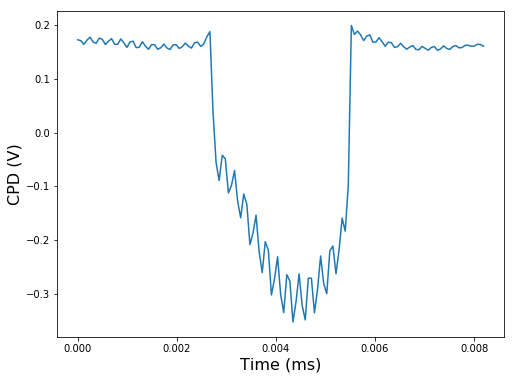

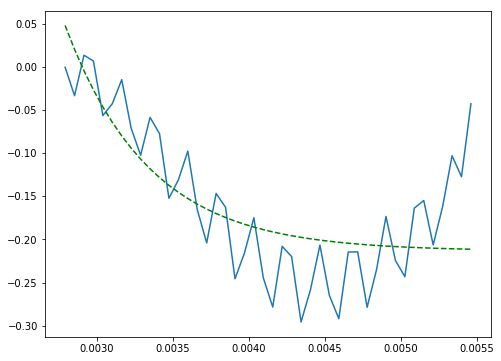

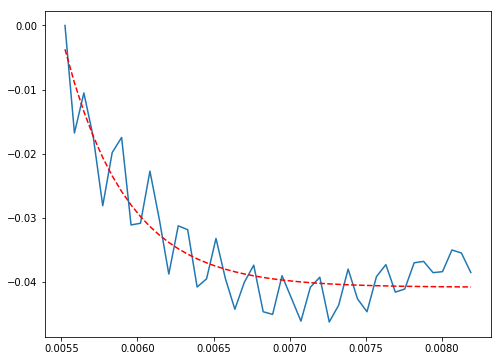

In [114]:
# Tests a single random CPD and shows the expected fits.
# This plots them separately if you wish to save for debugging purposes.

# random pixel
r = 32
c = 40

test = CPD[r*num_cols+c,:]
plt.figure(figsize=(8,6))
plt.plot(time,test)
plt.xlabel('Time (ms)', fontsize=16)
plt.ylabel('CPD (V)', fontsize=16)
#plt.savefig(output_filepath+'\CPD_sample.tif', format='tiff')

# Fit bounds and initial guesses
bds = ([-10, (1e-5), -5, time_on[0]-1e-10], 
       [10, (1e-1), 5, time_on[0]+1e-10])
p0s = [-0.025, 1e-3, 0, time_on[0]]

cut = CPD_on[r*num_cols + c, :] - CPD_on[r*num_cols + c, 0]
popt1, _ = curve_fit(fitexp, time_on, cut, bounds=bds, p0=p0s)
print(popt1[1]*1e3, ' ms CPD on tau')
plt.figure(figsize=(8,6))
plt.plot(time_on, cut)
plt.plot(time_on, fitexp(time_on, *popt1), 'g--')
#plt.savefig(output_filepath+'\CPD_on_fitting_example.tif', format='tiff')

bds = ([-10, (1e-5), -5, time_off[0]-1e-10], 
       [10, (1e-1), 5, time_off[0]+1e-10])

cut = CPD_off[r*num_cols + c, :] - CPD_off[r*num_cols + c, 0]
popt1, _ = curve_fit(fitexp, time_off, cut, bounds=bds )
print(popt1[1]*1e3, ' ms CPD off tau')
plt.figure(figsize=(8,6))
plt.plot(time_off, cut)
plt.plot(time_off, fitexp(time_off, *popt1), 'r--')
#plt.savefig(output_filepath+'\CPD_off_fitting_example.tif', format='tiff')

# The following are to test biexponential fits, but this hasn't proven useful to date. It's there for interest's sake
'''
bds_bion = ([1e-15,     1e-5,   1e-15,     1e-5,   -5, time_on[0]-1e-10], 
       [1,         1e-1,   5,      500,   5,  time_on[0]+1e-10])
cut = CPD_on[r*num_cols + c, :] - CPD_on[r*num_cols + c, 0]
popt1, _ = curve_fit(fitbiexp, time_on, cut, bounds=bds_bion)
print(popt1[1]*1e3, ' ms CPD on tau', popt1[3]*1e3,' ms CPD on tau2')
plt.figure(figsize=(8,6))
plt.plot(time_on, cut)
plt.plot(time_on, fitbiexp(time_on, *popt1), 'g--')
#plt.savefig(output_filepath+'\CPD_on_fitting_example-biexponential.tif', format='tiff')

bds_bioff = ([-5,     1e-5,   -5,     1e-5,   -5, time_off[0]-1e-10], 
       [-1e-15, 1e-1,   -1e-15,      500,   5,  time_off[0]+1e-10])
cut = CPD_off[r*num_cols + c, :] - CPD_off[r*num_cols + c, 0]
popt1, _ = curve_fit(fitbiexp, time_off, cut, bounds=bds_bioff)
print(popt1[1]*1e3, ' ms CPD off tau', popt1[3]*1e3,' ms CPD on tau2')
plt.figure(figsize=(8,6))
plt.plot(time_off, cut)
plt.plot(time_off, fitbiexp(time_off, *popt1), 'g--')
#plt.savefig(output_filepath+'\CPD_off_fitting_example-biexponential.tif', format='tiff')
'''

In [115]:
#%% Generate CPD

# Biexponential fitting makes this VERY VERY slow! Warning!
doBiexp_fit = False

print('#### Generating CPD rate images ####')
for r in np.arange(CPD_on_avg.shape[0]):

    if r%10 == 1:
        print('Row: ', r)
        print('Average CPD on = ', np.mean(CPD_on_time[r-1, :])*1e3,'ms')
        print('Average CPD off = ', np.mean(CPD_off_time[r-1, :])*1e3,'ms')

    for c in np.arange(CPD_on_avg.shape[1]):
        
        CPD_on_avg[r][c] = np.mean(CPD_on[r*num_cols + c,:])
        CPD_grad_on_avg[r][c] = np.mean(CPD_grad_on[r*num_cols + c,:])
        CPD_offset_on_avg[r][c] = np.mean(CPD_offset_on[r*num_cols + c,:])
        cut = CPD_on[r*num_cols + c, :] - CPD_on[r*num_cols + c, 0]
        try:
            popt, _ = curve_fit(fitexp, time_on, cut, 
                                bounds=bds_on, p0=p0on)
            CPD_on_time[r][c] = popt[1]
            CPD_on_mag[r][c] = popt[0]
            
            if doBiexp_fit == True:
                #biexponential
                popt, _ = curve_fit(fitbiexp, time_on, cut, bounds=bds_bion)
                CPD_bion_time[r][c] = popt[1]   # takes tau1, the "fast" part
        except:
            CPD_on_time[r][c] = CPD_on_time[r][c-1] # blur bad pixels
            CPD_bion_time[r][c] = CPD_bion_time[r][c-1] #blur bad pixels
            print( 'error_on')
            print(r, ' ', c)

        CPD_off_avg[r][c] = np.mean(CPD_off[r*num_cols + c,:])
        CPD_grad_off_avg[r][c] = np.mean(CPD_grad_off[r*num_cols + c,:])
        CPD_offset_off_avg[r][c] = np.mean(CPD_offset_off[r*num_cols + c,:])
        cut = CPD_off[r*num_cols + c, :] - CPD_off[r*num_cols + c, 0]
        try:
            popt, _ = curve_fit(fitexp, time_off, cut, bounds=bds_off)
            CPD_off_time[r][c] = popt[1]
            CPD_off_mag[r][c] = popt[0]
            
            if doBiexp_fit == True:
                #biexponential
                popt, _ = curve_fit(fitbiexp, time_off, cut, bounds=bds_bioff)
                CPD_bioff_time_fast[r][c] = popt[1]   # takes tau1, the "fast" part
                CPD_bioff_time_slow[r][c] = popt[3]   # takes tau1, the "fast" part
        except:
            CPD_off_time[r][c] = CPD_off_time[r][c-1] #blur bad pixels
            CPD_bioff_time_fast[r][c] = CPD_bioff_time_fast[r][c-1] #blur bad pixels
            CPD_bioff_time_slow[r][c] = CPD_bioff_time_slow[r][c-1] #blur bad pixels
            print( 'error')
            print(r, ' ', c)

SPV = CPD_on_avg - CPD_off_avg

#### Generating CPD rate images ####
Row:  1
Average CPD on =  0.5626397806826171 ms
Average CPD off =  1.1129513062921026 ms
Row:  11
Average CPD on =  0.5580557545799163 ms
Average CPD off =  1.1075938234136375 ms
Row:  21
Average CPD on =  0.560796391155097 ms
Average CPD off =  1.107962397899583 ms
Row:  31
Average CPD on =  0.5611954055570394 ms
Average CPD off =  1.1106591870646572 ms
Row:  41
Average CPD on =  0.5614417712841862 ms
Average CPD off =  1.1106237828239378 ms
Row:  51
Average CPD on =  0.5589220737596197 ms
Average CPD off =  1.1146689949055026 ms
Row:  61
Average CPD on =  0.5617961854902702 ms
Average CPD off =  1.114589895458611 ms


#### Saves CPD data to H5

In [116]:
# Saves text files to disk. You can also do this manually by finding the dataset in the HDF5 file
prefix = 'no' if PCA_post_reconstruction_clean else ''

np.savetxt(output_filepath+r'\CPD_on_'+prefix+'PCApost.txt', CPD_on_avg, delimiter=' ')
np.savetxt(output_filepath+r'\CPD_off_'+prefix+'PCApost.txt', CPD_off_avg, delimiter=' ')
np.savetxt(output_filepath+r'\CPD_on_time_'+prefix+'PCApost.txt', CPD_on_time, delimiter=' ')
np.savetxt(output_filepath+r'\CPD_off_time_'+prefix+'PCApost.txt', CPD_off_time, delimiter=' ')
np.savetxt(output_filepath+r'\CPDGrad_on_'+prefix+'PCApost.txt', CPD_grad_on_avg, delimiter=' ')
np.savetxt(output_filepath+r'\CPDGrad_off_'+prefix+'PCApost.txt', CPD_grad_off_avg, delimiter=' ')
np.savetxt(output_filepath+r'\CPDOffset_on_'+prefix+'PCApost.txt', CPD_offset_on_avg, delimiter=' ')
np.savetxt(output_filepath+r'\CPDOffset_off_'+prefix+'PCApost.txt', CPD_offset_off_avg, delimiter=' ')
np.savetxt(output_filepath+r'\SPV_'+prefix+'PCApost.txt', SPV, delimiter=' ')

# Save CPD to the H5 file
grp_name = h5_CPD.name
CPD_exists = usid.hdf_utils.find_dataset(h5_file[grp_name].parent, 'CPD_on_time')

if CPD_exists: 
    CPD_exists = usid.hdf_utils.find_dataset(h5_file[grp_name].parent, 'CPD_on_time')[0]
    CPD_exists = CPD_on_time
    
    CPD_exists = usid.hdf_utils.find_dataset(h5_file[grp_name].parent, 'CPD_off_time')[0]
    CPD_off_exists = CPD_off_time
    
    SPV_exists = usid.hdf_utils.find_dataset(h5_file[grp_name].parent, 'SPV')[0]
    SPV_exists = SPV
    
    print('Overwriting CPD Data!')
else:
    print('Creating new Datasets')
    
    # write the data directly to the CPD folder
    # in the future will need to make this a unique subfolder for multiple attempts
    dset = h5_file.create_dataset(h5_CPD.parent.name + '/CPD_on_time', CPD_on_time.shape)
    dset[:,:] = CPD_on_time[:,:]
    
    dset = h5_file.create_dataset(h5_CPD.parent.name + '/SPV', SPV.shape)
    dset[:,:] = SPV[:,:]
    
    dset = h5_file.create_dataset(h5_CPD.parent.name + '/CPD_off_time', CPD_off_time.shape)
    dset[:,:] = CPD_off_time[:,:]
    

Creating new Datasets


### Visualize the CPD Data

"\nfig, a = plt.subplots(nrows=1, figsize=(13, 3))\n_, cbar = px.plot_utils.plot_map(a, CPD_grad_resh_on_avg, cmap='inferno', aspect=aspect, \n                       x_vec=xv, y_vec = yv, stdevs = 2,\n                       cbar_label='Gradient (a.u.)')\ncbar.set_label('Time Constant (ms)', rotation=270, labelpad=16)\na.set_title('Capacitive Gradient', fontsize=12)\n\nif save_figure == True:\n    if PCA_post_reconstruction_clean == True:\n        fig.savefig(output_filepath+'\\CPD_gradient_PCA-Alone_'+str(clean_components)+'.tif', format='tiff')\n    else:\n        fig.savefig(output_filepath+'\\CPD_gradient_noPCA-Alone.tif', format='tiff') \n"

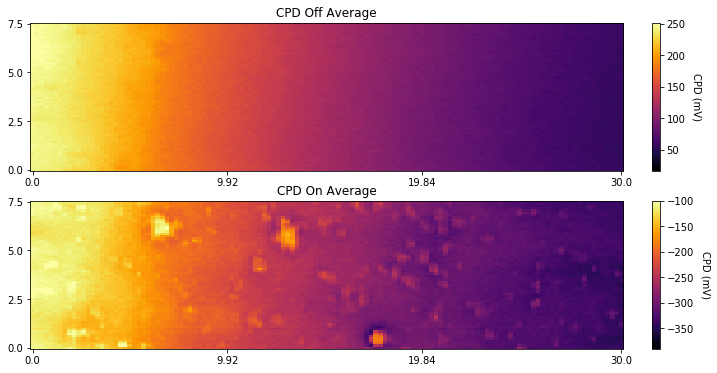

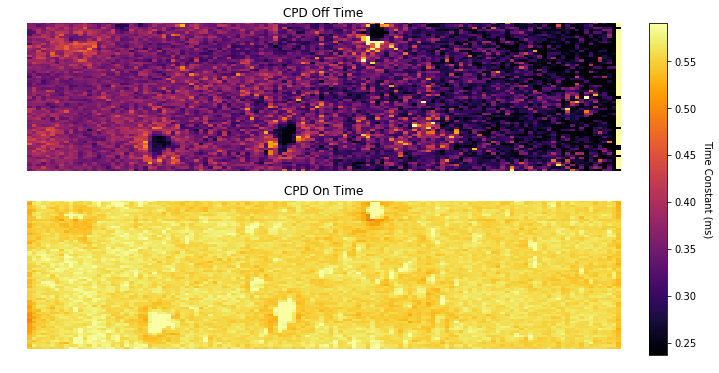

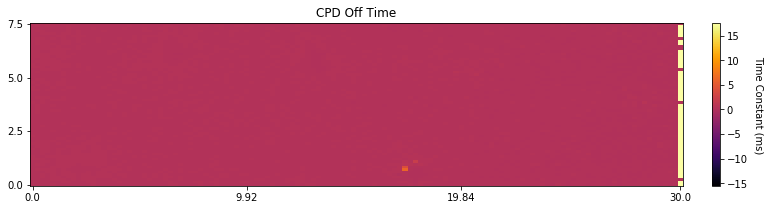

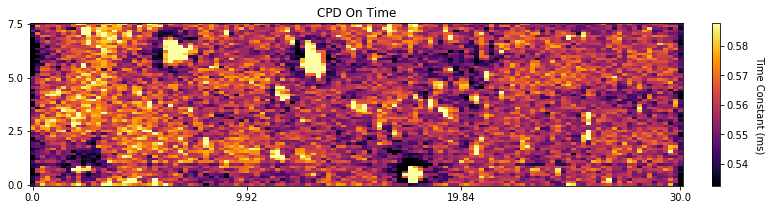

In [118]:
# Plotting

#1e3 to put in mV
mx = np.max([np.max(CPD_on_avg), np.max(CPD_off_avg)])*1e3
mn = np.min([np.min(CPD_on_avg), np.min(CPD_off_avg)])*1e3
xv = np.linspace(0,img_length*1e6, num_cols)
yv = np.linspace(0,img_height*1e6, num_rows)

# Plots the CPD averages
fig, a = plt.subplots(nrows=2, figsize=(13, 6))
_, cbar = usid.plot_utils.plot_map(a[0], CPD_off_avg*1e3, cmap='inferno', aspect=aspect, 
                       x_vec=xv, y_vec = yv, stdevs = 2,
                       cbar_label='CPV (mV)')
cbar.set_label('CPD (mV)', rotation=270, labelpad=16)
a[0].set_title('CPD Off Average', fontsize=12)

_, cbar = usid.plot_utils.plot_map(a[1], CPD_on_avg*1e3, cmap='inferno', aspect=aspect, 
                       x_vec=xv, y_vec = yv, stdevs = 2,
                       cbar_label='CPV (mV)')
cbar.set_label('CPD (mV)', rotation=270, labelpad=16)
a[1].set_title('CPD On Average', fontsize=12)

if save_figure == True:
    if PCA_post_reconstruction_clean == True:
        fig.savefig(output_filepath+'\CPDon_vs_off_PCApost.eps', format='eps')
        fig.savefig(output_filepath+'\CPDon_vs_off_PCApost_'+str(clean_components)+'.tif', format='tiff')
    else:
        fig.savefig(output_filepath+'\CPDon_vs_off_noPCApost.eps', format='eps')
        fig.savefig(output_filepath+'\CPDon_vs_off_noPCApost.tif', format='tiff')
    
# some clean-up for plotting to remove curve-fit errors; only for setting color range
from scipy import signal
testC = signal.medfilt(CPD_on_time, kernel_size=[3,3])
testD = signal.medfilt(CPD_off_time, kernel_size=[3,3])

mnC = (np.mean(testC) - 2*np.std(testC))*1e3
mxC = (np.mean(testC) + 2*np.std(testC))*1e3
mnD = (np.mean(testD) - 2*np.std(testD))*1e3
mxD = (np.mean(testD) + 2*np.std(testD))*1e3
mn = np.min([mnC, mnD])
mx = np.max([mxC, mxD])

# Plots the CPD Time Constants
fig = plt.figure(figsize=(13,6))
a = fig.add_subplot(211)
a.set_axis_off()
a.set_title('CPD Off Time', fontsize=12)
a.imshow(CPD_off_time*1e3, cmap='inferno', vmin=mn, vmax=mx, aspect=aspect)

a = fig.add_subplot(212)
a.set_axis_off()
a.set_title('CPD On Time', fontsize=12)
im = a.imshow(CPD_on_time*1e3, cmap='inferno', vmin=mn, vmax=mx, aspect=aspect)

cx = fig.add_axes([0.86, 0.11, 0.02, 0.77])
cbar = fig.colorbar(im, cax=cx)
cbar.set_label('Time Constant (ms)', rotation=270, labelpad=16)

if save_figure == True:
    if PCA_post_reconstruction_clean == True:
        fig.savefig(output_filepath+'\CPD_times_noPCA.tif', format='tiff')
    else:
        fig.savefig(output_filepath+'\CPD_times_PCA_'+str(clean_components)+'.tif', format='tiff')

# Plots the CPD time constants separately for auto-contrasting purposes
fig, a = plt.subplots(nrows=1, figsize=(13, 3))

_, cbar = usid.plot_utils.plot_map(a, CPD_off_time*1e3, cmap='inferno', aspect=aspect, 
                       x_vec=xv, y_vec = yv, stdevs = 2,
                       cbar_label='Time Constant (ms)')
cbar.set_label('Time Constant (ms)', rotation=270, labelpad=16)
a.set_title('CPD Off Time', fontsize=12)

if save_figure == True:
    if PCA_post_reconstruction_clean == True:
        fig.savefig(output_filepath+'\CPDoff_times_PCA-Alone_'+str(clean_components)+'.tif', format='tiff')
    else:
        fig.savefig(output_filepath+'\CPDoff_times_noPCA-Alone.tif', format='tiff')    

fig, a = plt.subplots(nrows=1, figsize=(13, 3))
_, cbar = usid.plot_utils.plot_map(a, CPD_on_time*1e3, cmap='inferno', aspect=aspect, 
                       x_vec=xv, y_vec = yv, stdevs = 2,
                       cbar_label='Time Constant (ms)')
cbar.set_label('Time Constant (ms)', rotation=270, labelpad=16)
a.set_title('CPD On Time', fontsize=12)

if save_figure == True:
    if PCA_post_reconstruction_clean == True:
        fig.savefig(output_filepath+'\CPDon_times_PCA-Alone_'+str(clean_components)+'.tif', format='tiff')
    else:
        fig.savefig(output_filepath+'\CPDon_times_noPCA-Alone.tif', format='tiff')    

# Optionally displays the CPD gradient
'''
fig, a = plt.subplots(nrows=1, figsize=(13, 3))
_, cbar = px.plot_utils.plot_map(a, CPD_grad_resh_on_avg, cmap='inferno', aspect=aspect, 
                       x_vec=xv, y_vec = yv, stdevs = 2,
                       cbar_label='Gradient (a.u.)')
cbar.set_label('Time Constant (ms)', rotation=270, labelpad=16)
a.set_title('Capacitive Gradient', fontsize=12)

if save_figure == True:
    if PCA_post_reconstruction_clean == True:
        fig.savefig(output_filepath+'\CPD_gradient_PCA-Alone_'+str(clean_components)+'.tif', format='tiff')
    else:
        fig.savefig(output_filepath+'\CPD_gradient_noPCA-Alone.tif', format='tiff') 
'''

#### Visualize SPV

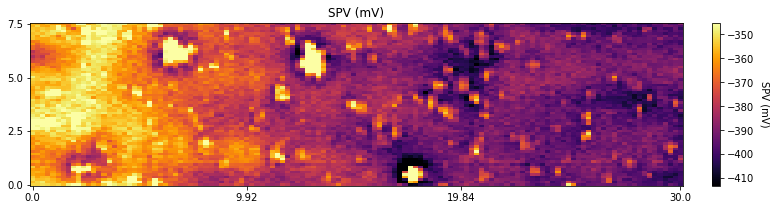

In [120]:
# SPV plotting

# 1e3 to put in mV
fig, a = plt.subplots(nrows=1, figsize=(13, 3))
_, cbar = usid.plot_utils.plot_map(a, SPV*1e3, cmap='inferno', aspect=aspect, 
                       x_vec=xv, y_vec=yv, stdevs = 2,
                       cbar_label='SPV (mV)')
cbar.set_label('SPV (mV)', rotation=270, labelpad=16)
a.set_title('SPV (mV)', fontsize=12)

if save_figure == True:
    if PCA_post_reconstruction_clean == True:
        fig.savefig(output_filepath+'\SPV_PCApost.eps', format='eps')
        fig.savefig(output_filepath+'\SPV_PCApost_'+str(clean_components)+'.tif', format='tiff')
    else:
        fig.savefig(output_filepath+'\SPV_noPCApost.eps', format='eps')
        fig.savefig(output_filepath+'\SPV_noPCApost.tif', format='tiff')

#### Visualize the CPD at several random pixels

0.00034227643393861505  s CPD off time at  35   17
0.0005737001492532013  s CPD on time at  35   17
0.00036425991522076264  s CPD off time at  49   12
0.000561602435476554  s CPD on time at  49   12
0.0003121276309530868  s CPD off time at  4   55
0.000582722136580472  s CPD on time at  4   55
0.000318708703850456  s CPD off time at  32   77
0.0005528844675072474  s CPD on time at  32   77
0.0002790795464359325  s CPD off time at  28   75
0.0005732392998353735  s CPD on time at  28   75


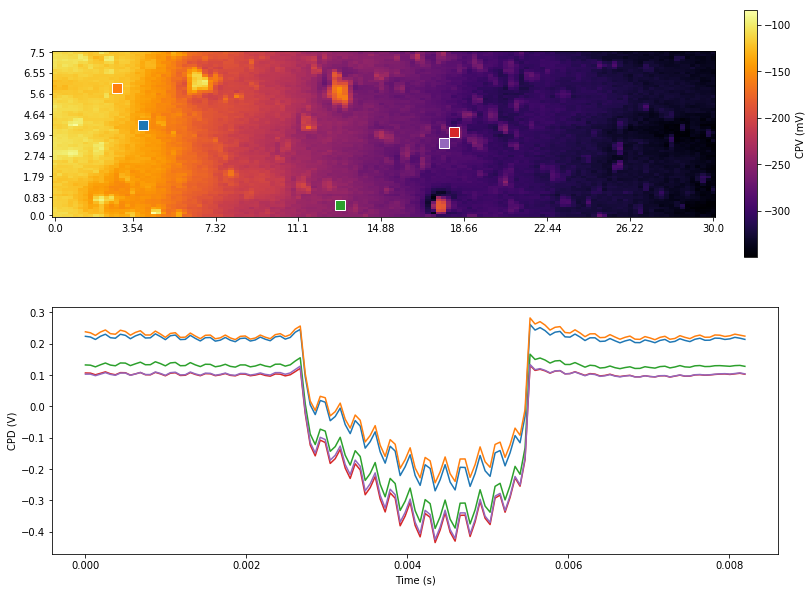

In [122]:
# points for CPD slices

# Input the coordinates in unit length that you wish to plot
# these are in x:y format (column:row)
indices = {.1:1,
           4.1:1,
           4.2:6,
           7.8:.9,
           12:3,
           17.2:4.7,
           24:7,
           30:3
           }

img_length = parms_dict['FastScanSize']
img_height = parms_dict['SlowScanSize']

# Random indices to check the CPD
useRandomPixels = True
if useRandomPixels:
    
    keys = np.random.randint(0, num_cols, size=[5])*img_length*1e6/num_cols
    vals = np.random.randint(0, num_rows, size=[5])*img_height*1e6/num_rows
    indices = dict(zip(keys, vals))
        
cptslabels = [k for k in indices] #column points, row points
rptslabels = [k for k in indices.values()]
cpts = [int(i) for i in np.round(np.array(cptslabels) * (1e-6/ img_length) * num_cols)]
rpts = [int(i) for i in np.round(np.array(rptslabels) * (1e-6/ img_height) * num_rows)]

#cpts = [69, 76] #column points, row points
#rpts = [4, 4]
linecoords = np.arange(rpts[0]*num_cols + cpts[0], rpts[0]*num_cols + cpts[1])

fig, a = plt.subplots(nrows=2, figsize=(13, 10), facecolor='white')
im0 = usid.plot_utils.plot_map(a[0], CPD_on_avg*1e3, cmap='inferno', origin='lower', aspect=0.5,
                             x_vec=xv, y_vec=yv, num_ticks=9,
                             cbar_label='CPV (mV)')

time = np.linspace(0.0, pxl_time, CPD.shape[1])
dtCPD = pxl_time/CPD.shape[1] #dt for the CPD since not same length as raw data

colors = ['C'+str(i) for i in np.arange(0,len(cpts))]
markers =  ['C'+str(i)+'s' for i in np.arange(0,len(cpts))]

for k,j,m,c in zip(cpts, rpts, markers, colors):
    a[0].plot(k, j, m, markersize=10, mec='white', mew=1)
    a[1].plot(time, CPD[j*num_cols + k,:], c)
    a[1].set_xlabel('Time (s)')
    a[1].set_ylabel('CPD (V)')
    print(CPD_off_time[j, k], ' s CPD off time at ', j, ' ', k)
    print(CPD_on_time[j, k], ' s CPD on time at ', j, ' ', k)
    
if save_figure == True:
    if PCA_post_reconstruction_clean == True:
        fig.savefig(output_filepath+'\CPD_slices_PCApost.tif', format='tiff')
    else:
        fig.savefig(output_filepath+'\CPD_slices_noPCApost.tif', format='tiff')

#### PCA of the CPD data

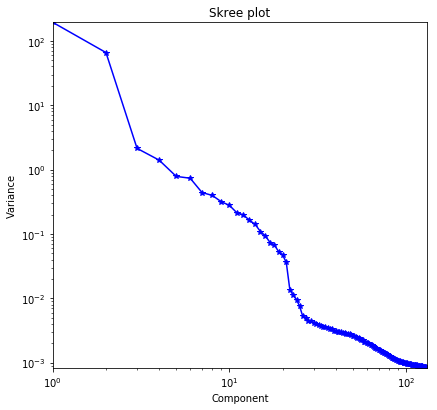

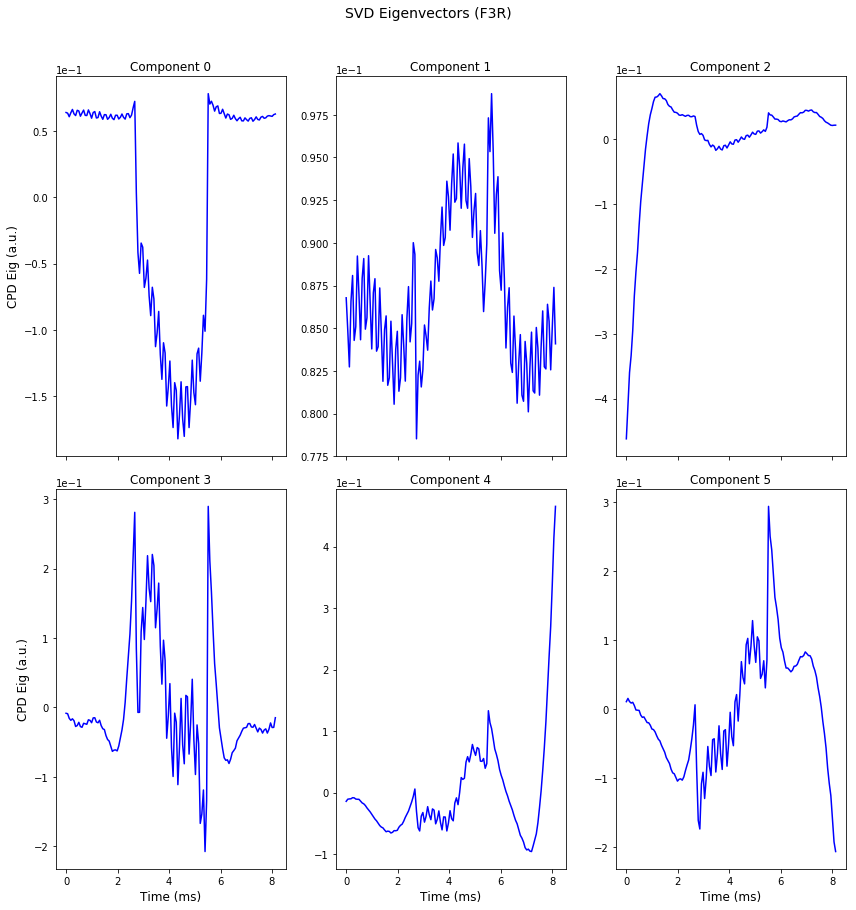

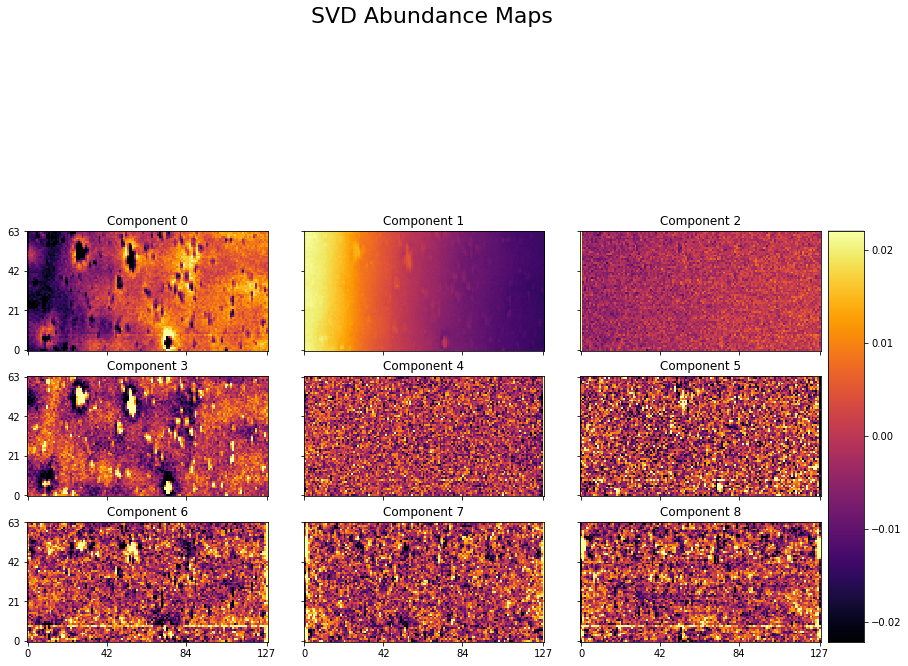

In [123]:
# Shows where most of the information in the CPD is, in terms of principal components
from sklearn.utils.extmath import randomized_svd

U, S, V = randomized_svd(CPD[:,:-1], 256, n_iter=3)

# Since the two spatial dimensions (x, y) have been collapsed to one, we need to reshape the abundance maps:
abun_maps = np.reshape(U[:,:25], (num_rows, num_cols,-1))

# Visualize the variance / statistical importance of each component:
fig, axes = usid.plot_utils.plot_scree(S, title='Skree plot')

if save_figure == True:
    fig.savefig(output_filepath+'\CPDtotal_Skree.tif', format='tiff')


# Visualize the eigenvectors:
first_evecs = V[:6, :]

fig, axes = usid.plot_utils.plot_curves(time[:-1]*1E+3, first_evecs, x_label='Time (ms)', y_label='CPD Eig (a.u.)', num_plots=9,
                         subtitle_prefix='Component', title='SVD Eigenvectors (F3R)', evenly_spaced=False)

if save_figure == True:
    fig.savefig(output_filepath+'\CPDtotal_Eig.tif', format='tiff')

# Visualize the abundance maps:
fig, axes = usid.plot_utils.plot_map_stack(abun_maps, num_comps=9, title='SVD Abundance Maps',
                             color_bar_mode='single', cmap='inferno', reverse_dims=True)

if save_figure == True:
    fig.savefig(output_filepath+'\CPDtotal_Loadings.tif', format='tiff')

#### Visualize the CPD over time

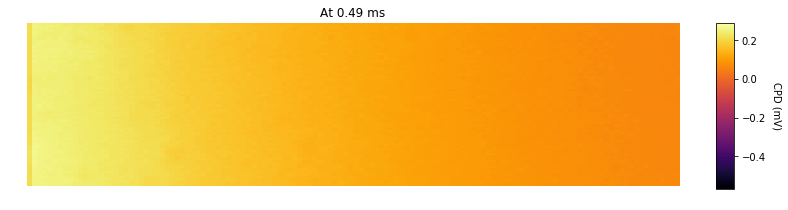

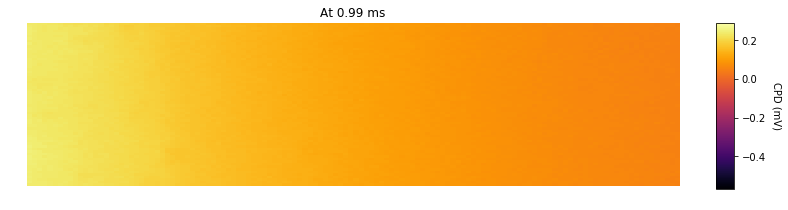

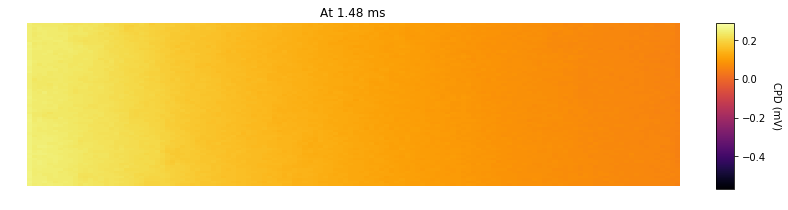

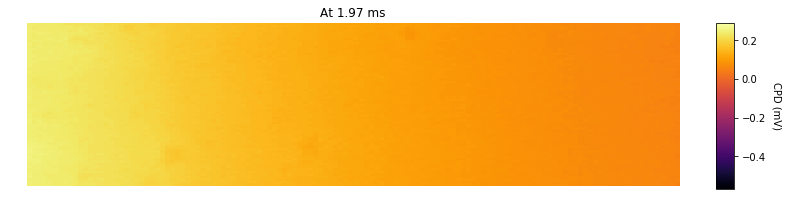

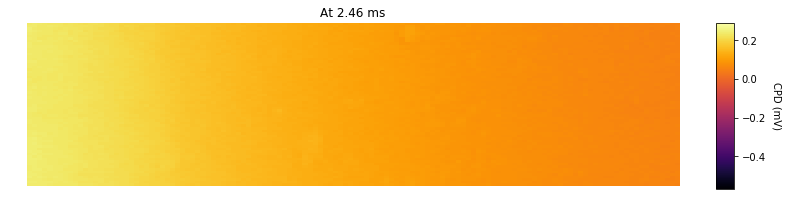

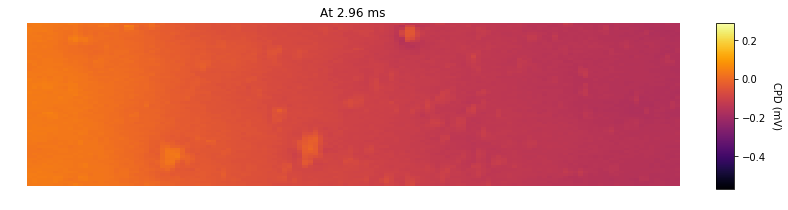

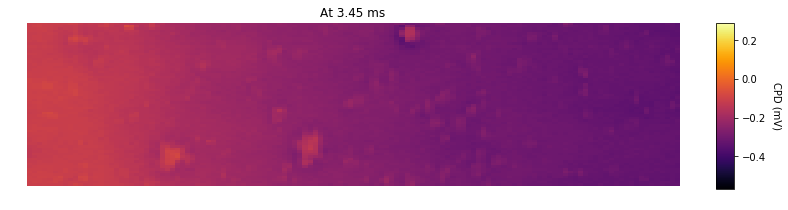

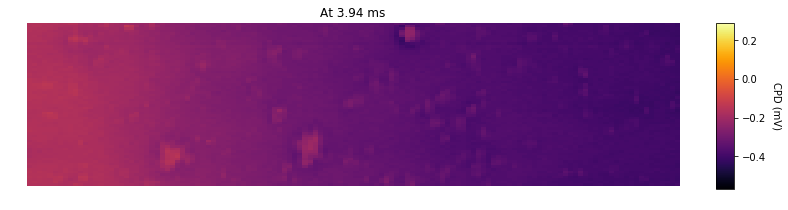

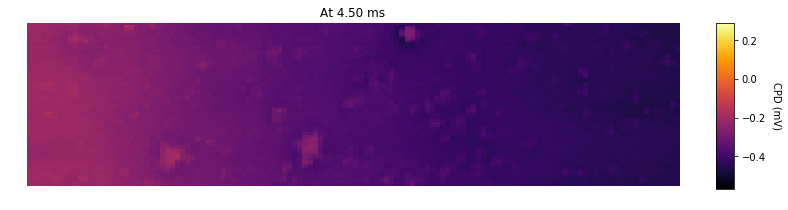

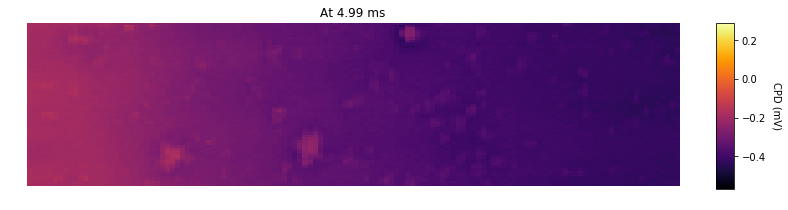

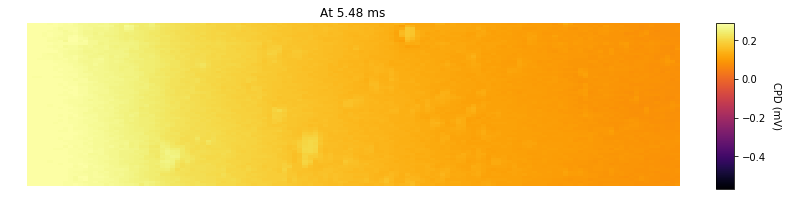

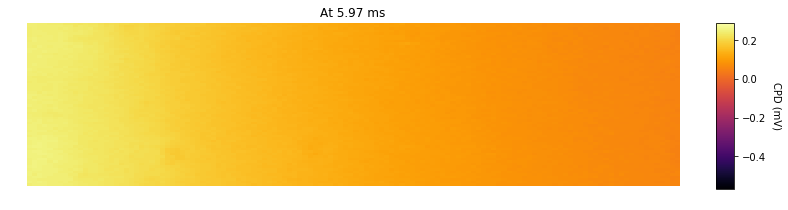

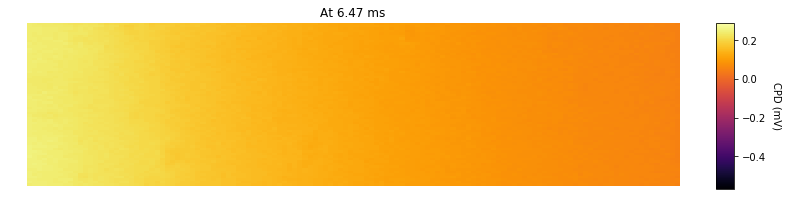

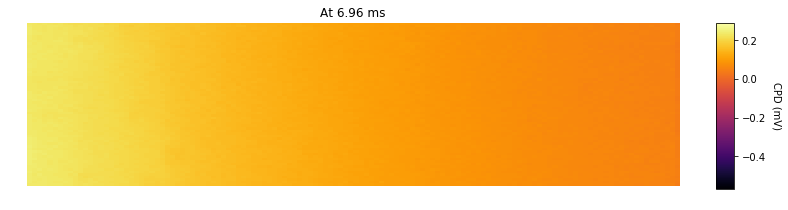

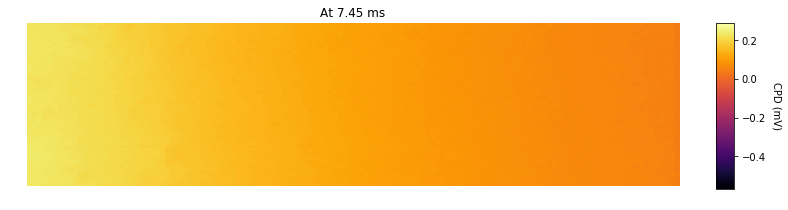

In [124]:
#%% CPD Time Slices

timeslice = np.floor(np.arange(0.5, 8, .5) *1e-3/dtCPD)

# find correct mn and mx for color scale
# you can manually change mn and mx after running this block to maximize the contrast
CPD_mn = np.reshape(CPD[:, p_on+int((p_off-p_on)/2)], [64, 128])
mn = np.mean(CPD_mn) - 2.5*np.std(CPD_mn)
CPD_mx = np.reshape(CPD[:, p_off+int((CPD.shape[1]-p_off)/2)], [64, 128])
mx = np.mean(CPD_mx) + 3*np.std(CPD_mx)

#mn = -.13
#mx = -.0600
for k in timeslice:
    fig = plt.figure(figsize=(13,3))
    a = fig.add_subplot(111)
    CPD_rs = np.reshape(CPD[:, int(k)], [64, 128])
    im = a.imshow(CPD_rs, cmap='inferno', vmin=mn, vmax=mx, aspect=aspect)
    a.set_axis_off()
    tl = '{0:.2f}'.format(k*dtCPD/1e-3)
    plt.title('At '+ tl + ' ms', fontsize=12)
    cx = fig.add_axes([0.9, 0.11, 0.02, 0.77])
    cbar = fig.colorbar(im, cax=cx)
    cbar.set_label('CPD (mV)', rotation=270, labelpad=16)
    #fig.savefig(output_filepath+'\CPDslice_' + tl + '_ms.eps', format='eps')
    fig.savefig(output_filepath+'\CPDslice_' + tl + '_ms.tif', format='tiff')

#### Visualize the CPD spatially across a subset of the image

In [ ]:
#%% Cross-sectional animation, setup

'''
Set the cooordinates to draw a line across here. 
1) Note these are in in length units (in microns here)! 
2) Rpts must have same start and finish. This segment only allows horizontal lines at this time. Sorry!
'''
cptslabels = [16, 20] #column points, row points
rptslabels = [3  , 3]

cpts = [int(i) for i in np.array(cptslabels) * (1e-6/ img_length) * num_cols]
rpts = [int(i) for i in np.array(rptslabels) * (1e-6/ img_height) * num_rows]

#cpts = [69, 76] #column points, row points
#rpts = [4, 4]
linecoords = np.arange(rpts[0]*num_cols + cpts[0], rpts[0]*num_cols + cpts[1])

clen = cpts[1] - cpts[0]
rlen = rpts[1] - rpts[0]
pxl_size = img_length/num_cols #meter length of a pixel
pxl_ht = img_height/num_rows #meter height of a pixel
dtCPD = pxl_time/CPD.shape[1] #dt for the CPD since not same length as raw data
p_on = int(light_on_time[0]*1e-3 / dtCPD) 
p_off = int(light_on_time[1]*1e-3 / dtCPD) 

ccoords = np.arange(cpts[0],cpts[1])
rcoords = np.arange(rpts[0],rpts[1])

time = np.linspace(0.0, pxl_time, CPD.shape[1])
xax = ccoords*pxl_size*1e6

fig, a = plt.subplots(nrows=3, figsize=(13, 10), facecolor='white')
im0 = a[0].imshow(CPD_on_avg, cmap='inferno', origin='lower',
                    extent=[0, img_length*1e6, 0, img_height*1e6])
cbar = plt.colorbar(im0, ax=a[0], orientation='vertical',
                    fraction=0.046, pad=0.01, use_gridspec=True)
cbar.set_label('CPD (V)', rotation=270, labelpad = 20)
a[0].plot(ccoords*pxl_size*1e6, rpts[0]*pxl_ht*1e6*np.ones(len(ccoords)), 'w')

ims = []
a[1].set_ylabel('Normalized CPD (mV)')

a[2].set_xlabel('Distance (um)')
a[2].set_ylabel('CPD (mV)')

txtcoord = np.max(CPD[linecoords,0])*1e3

#Colorscale
# Here you should change this to best accentuate the contrast in the image. 
CPD_mn = np.reshape(CPD[:, p_on+int((p_off-p_on)/2)], [64, 128])
mn = np.mean(CPD_mn) - 3*np.std(CPD_mn)
CPD_mx = np.reshape(CPD[:, p_off+int((CPD.shape[1]-p_off)/2)], [64, 128])
mx = np.mean(CPD_mx) + 3*np.std(CPD_mx)

displays = np.array([1, p_on, int(p_on+(p_off-p_on)/2), p_off, pnts_per_CPDpix-5])
markers = ['^-','o-','s-','D-', 'v-']
labels = ['{0:.2f}'.format(i*dtCPD/1e-3)+ ' ms' for i in displays]

for k in range(len(displays)):
    CPD_rs = np.reshape(CPD[:, displays[k]], [64, 128])
    sectn = CPD[linecoords,displays[k]]
    a[1].plot(xax, (sectn-np.min(sectn))/(np.max(sectn)-np.min(sectn)), markers[k], label=labels[k]) 
    a[2].plot(xax, sectn*1e3, markers[k], markersize=8, label=labels[k]) 

length_labels = str(cptslabels[0])+'-'+str(cptslabels[1])+'um_at_'+str(rptslabels[0])+'_um'
fig.savefig(output_filepath+'\CPD_composite_'+length_labels+'.tif', format='tif')

a[1].legend(fontsize='12')
fig.savefig(output_filepath+'\CPD_composite_'+length_labels+'_legend.tif', format='tif')

#### Animate the above graphic over time! 

In [ ]:
'''
Change the following line to use the FFMPeg .Exe file on your local drive.

This animation will be saved on your local folder, it will not display live in Jupyter. It takes a few minutes to process
'''

import matplotlib.animation as animation
plt.rcParams['animation.ffmpeg_path'] = r'C:\Users\Raj\Downloads\ffmpeg-20180124-1948b76-win64-static\bin\ffmpeg.exe'

fig, a = plt.subplots(nrows=3, figsize=(13, 10), facecolor='white')
im0 = a[0].imshow(CPD_on_avg, cmap='inferno', origin='lower',
                    extent=[0, img_length*1e6, 0, img_height*1e6])
cbar = plt.colorbar(im0, ax=a[0], orientation='vertical',
                    fraction=0.046, pad=0.01, use_gridspec=True)
cbar.set_label('CPD (V)', rotation=270, labelpad = 20)
a[0].plot(ccoords*pxl_size*1e6, rpts[0]*pxl_ht*1e6*np.ones(len(ccoords)), 'w')

ims = []
a[1].set_ylabel('Normalized CPD (mV)')

a[2].set_xlabel('Distance (um)')
a[2].set_ylabel('CPD (mV)')

txtcoord = np.max(CPD[linecoords,0])*1e3

for k in np.arange(time.shape[0]):
    
    CPD_rs = np.reshape(CPD[:, int(k)], [64, 128])
    im0 = a[0].imshow(CPD_rs, cmap='inferno', origin='lower',
                    extent=[0, img_length*1e6, 0, img_height*1e6], vmin=mn, vmax=mx)
    
    a[0].plot(ccoords*pxl_size*1e6, rpts[0]*pxl_ht*1e6*np.ones(len(ccoords)), 'w')
    
    if k in np.arange(p_on,p_off):
        tl0 = a[0].text(img_length/2*1e6 - 1, img_height*1e6+0.1, 'LIGHT ON', color='blue', weight='bold')
    else:
        tl0 = a[0].text(img_length/2*1e6 - 1, img_height*1e6+0.1, 'LIGHT OFF', color='black', weight='regular')
    sectn = CPD[linecoords,k]
    im1, = a[1].plot(xax, (sectn-np.min(sectn))/(np.max(sectn)-np.min(sectn)), 'r^-')   #comma unpacks into a list to add titles
    htitle = 'At '+ '{0:.2f}'.format(k*dtCPD/1e-3)+ ' ms'
    tl1 = a[1].text(xax[int(xax.shape[0]/2)], 1.05, htitle)
    
    im2, = a[2].plot(xax, sectn*1e3, 'bo-')   #comma unpacks into a list to add titles
    htitle = 'At '+ '{0:.2f}'.format(k*dtCPD/1e-3)+ ' ms'
    #tl2 = a[2].text(xax[int(xax.shape[0]/2)], txtcoord+5, htitle)
    ims.append([im0, tl0, im1, tl1, im2])

ani = animation.ArtistAnimation(fig, ims, interval=60,repeat_delay=10)

ani.save(output_filepath+'\CPD_graph_'+length_labels+'.mp4')

#### Visualize via k-means Clustering

In [ ]:
from ffta.utils import dist_cluster, mask_utils
import badpixels

# Specify number of clusters here
clusters=5

img_length = parms_dict['FastScanSize']
img_height = parms_dict['SlowScanSize']
group = h5_main.name + '-CPD'

mask_path = r'G:\Team Drives\201805_BAPI_paper_source_data\GSKPM\Masks\Mask_BAPI20_0008.txt'

mask = mask_utils.load_mask_txt(mask_path, flip=False)

CPD_file = px.hdf_utils.find_dataset(h5_file, 'CPD')[-1]
if CPD_file.name.split('/')[-1] != 'CPD':
    CPD_file = px.hdf_utils.find_dataset(CPD_file.parent, 'CPD')[0]

for k in parms_dict:
    CPD_file.parent.attrs[k] = parms_dict[k]
    CPD_file.parent.attrs['trigger'] = 0 # since kmeans designed for fftrEFM code, this is a fake flag

CPD_clust = dist_cluster.dist_cluster(CPD_file,data_avg='CPD_on_avg', mask=mask, isCPD=True) 
#                                       imgsize=[img_length, img_height], light_on=light_on_time)

# destreak image
fa, bpl = badpixels.find_bad_pixels(CPD_clust.data_avg, 1)
fa = badpixels.remove_bad_pixels(CPD_clust.data_avg, fa, bpl)
CPD_clust.data_avg = fa[:,:]

CPD_clust.analyze()
#_, _, fig = CPD_clust.kmeans(CPD_clust.CPD_scatter, show_results=True,clusters=clusters)
CPD_clust.kmeans(clusters=clusters)
fig, ax = CPD_clust.plot_img()
if save_figure == True:
    fig.savefig(output_filepath+'\masked_image-'+'.tif', format='tiff')

fig, _ = CPD_clust.plot_kmeans()
if save_figure == True:
    fig.savefig(output_filepath+'\k_means_vs_grain_distance_numclusters-'+str(CPD_clust.results.cluster_centers_.shape[0])+'.tif', format='tiff')

fig, _ = CPD_clust.heat_map()
if save_figure == True:
    fig.savefig(output_filepath+'\k_means_vs_grain_distance_heat_map_numclusters-'+str(CPD_clust.results.cluster_centers_.shape[0])+'.tif', format='tiff')

CPD_clust.segment_maps()
CPD_clust.plot_segment_maps(ax)

if save_figure == True:
    fig.savefig(output_filepath+'\clustered_CPD-'+str(CPD_clust.results.cluster_centers_.shape[0])+'.tif', format='tiff')

fig, ax = CPD_clust.plot_centers()
ax.set_ylabel('CPD (V)')
ax.set_xlabel('Time (s)')
if save_figure == True:
    fig.savefig(output_filepath+'\CPD_cluster_centers-'+str(CPD_clust.results.cluster_centers_.shape[0])+'.tif', format='tiff')

fig, ax = CPD_clust.plot_img()

In [125]:
hdf.close()